Building a winning National Basketball Association (NBA) rotation is a conundrum every NBA coach faces. Coaches have historically relied on their experience, player’s strengths and opponent’s weaknesses to plan their game day roster but with the advances made in the field of sport analytics, analytics is now playing a significant role in the game day planning process. Key to putting a winning rotation together is knowing each player's scoring potential. This project aims to address this key unknown by utilizing basketball shot data to predict single game points for each player on an NBA team. Having this knowledge ahead of each game will arm NBA coaches with vital data driven information that would lead to better game day strategies and more winning rotations.

In this project, I built a Poisson model to predict single game points for each NBA player on a specific team. The team of interest for this project is the Los Angeles Clippers(LAC) with focus on the 2025 season team's top three game scorers ( James Harden, Kawhi Leonard and Norman Powell). Although this project's focus was on the LAC team, the Poisson model can be easilly updated to predict single game points for any other NBA team.

Dataset Description

Three datasets were combined and used to build the Poisson model and the combined dataset consists of the following variables:

**season** : NBA season (Quantitative)

**game_date** : Date game was played (Date)

**game_id**: Game identification number (Quantitative)

**athlete_display_name** : NBA player's name (Qualitative)

**athlete_id** : NBA player's identification number(Quantitative)

**team_abbreviation** : Abbreviation for the name of the team of interest(Qualitative)

**team_name** : Name of team of interest(Qualitative)

**minutes** : Minutes played by the player in the game(Quantitative)

**field_goals_made**: Field goals made by the player in the game(Quantitative)

**field_goals_attempted**: Field goals attempted by the player in the game (Quantitative)

**three_point_field_goals_made**: Number of three point field goals made by the player in the game (Quantitative)

**three_point_field_goals_attempted**: Number of three point field goals attempted by the player in the game (Quantitative)

**free_throws_made**: Number of free throws made by the player in the game (Quantitative)

**free_throws_attempted**: Number of free throws attempted by the player in the game (Quantitative)

**offensive_rebounds** : Number of offensive rebounds made by the player in the game (Quantitative)

**geFGp** : Effective field goal percentage of the player in the game (Quantitative)

**gTSp** : True shooting percentage of the player in the game (Quantitative)

**WSp48** : Season average number of wins contributed by the player per 48 minutes of game time   (Quantitative)

**FGp** : Average season field goal percentage of the player (Quantitative)

**defensive_rebounds** : Number of defensive rebounds made by the player in the game (Quantitative)

**rebounds** : Number of rebounds made by the player in the game (Quantitative)

**assists** : Number of assists made by the player in the game (Quantitative)

**steals** : Number of steals made by the player in the game (Quantitative)

**blocks** : Number of blocks made by the player in the game (Quantitative)

**turnovers** : Number of turnovers made by the player in the game (Quantitative)

**fouls** : Number of fouls committed by the player in the game (Quantitative)

**plus_minus** : Number of points a team gained or lost relative to the opponent when the player is in the game (Quantitative)

**home_away** : Location of game(Qualitative)

**team_winner** : Determines if the player made the team win the game(Qualitative)

**team_score** : Final team score in the game ( Quantitative)

**opponent_team_name** : Opponent team for the game (Qualitative)

**opponent_team_score** : Opponent team score in the game (Quantitative)

**points** : This is the response variable. It represents the total points scored by the player from the team of interest in the game



In [2]:
#Install needed packages
install.packages("gtExtras")
install.packages("hoopR")
install.packages("ggrepel")
install.packages("corrplot")
install.packages("RColorBrewer")


The downloaded binary packages are in
	/var/folders/51/32q7pybd6hn6pgm_7hg6w6780000gn/T//RtmpK8Rkbt/downloaded_packages

The downloaded binary packages are in
	/var/folders/51/32q7pybd6hn6pgm_7hg6w6780000gn/T//RtmpK8Rkbt/downloaded_packages

The downloaded binary packages are in
	/var/folders/51/32q7pybd6hn6pgm_7hg6w6780000gn/T//RtmpK8Rkbt/downloaded_packages

The downloaded binary packages are in
	/var/folders/51/32q7pybd6hn6pgm_7hg6w6780000gn/T//RtmpK8Rkbt/downloaded_packages

The downloaded binary packages are in
	/var/folders/51/32q7pybd6hn6pgm_7hg6w6780000gn/T//RtmpK8Rkbt/downloaded_packages


### Dataset Preparation

In [66]:
#Load all needed libraries
library(ggplot2)
library(car)
library(dplyr)
library(glmnet)
library(hoopR)
library(gtExtras)
library(lubridate)
library(ggrepel)
library(corrplot)



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




In [4]:
#Load datasets 
nba<- load_nba_player_box(2021:2025)
nba_filter <- filter(nba,game_date < "2025-04-25" )
write.csv(nba_filter,"nbadata.csv",row.names = FALSE)
nbadata<- read.csv("nbadata.csv", header = TRUE)
nrow(nbadata)
shootacc_brefad <- read.csv("Bref_Advanced.csv", header=TRUE)
shootacc_bref <- read.csv("Bref_Shooting.csv", header=TRUE)



[1] 167920

In [6]:
#Data Wrangling to merge datasets into one and select only LAC games only

#get nbadata column names
nbadata_cols <- colnames(nbadata)

nba_cols <- c('game_id','season','game_date','athlete_id','athlete_display_name','team_name',
              'minutes','field_goals_made','field_goals_attempted','three_point_field_goals_made',
              'three_point_field_goals_attempted','free_throws_made','free_throws_attempted','offensive_rebounds','defensive_rebounds',
              'rebounds','assists','steals','blocks','turnovers','fouls','plus_minus','points','starter','ejected','did_not_play',
              'reason','active','athlete_position_name','athlete_position_abbreviation','team_abbreviation','home_away','team_winner','team_score','opponent_team_id','opponent_team_name'
              ,'opponent_team_score')

#select relevant columns from nba data dataframe 
nbadata_sub <- nbadata[nba_cols]

#select relevant columns from shootacc_brefad dataframe
shootacc_brefadsub <- shootacc_brefad[c("Year","Player","Team", "WSp48")]

# address player names mismatch between nba data and shootacc_brefad for only LAC players
shootacc_brefadsub$Player[shootacc_brefadsub$Player == "Marcus Morris"] <- "Marcus Morris Sr."
shootacc_brefadsub$Player[shootacc_brefadsub$Player == "Brandon Boston Jr."] <- "Brandon Boston"
shootacc_brefadsub$Player[shootacc_brefadsub$Player == "Moussa Diabaté"] <- "Moussa Diabate"
shootacc_brefadsub$Player[shootacc_brefadsub$Player == "Bogdan Bogdanović"] <- "Bogdan Bogdanovic"

#rename columns
names(shootacc_brefadsub) <- c('season','athlete_display_name','team_abbreviation','WSp48')



#select relevant columns from shootacc_bref dataframe
shootacc_brefsub <- shootacc_bref[c("Year","Player","Team","FGp")]

# address player names mismatch between nba data and shootacc_bref for only LAC players
shootacc_brefsub$Player[shootacc_brefsub$Player == "Marcus Morris"] <- "Marcus Morris Sr."
shootacc_brefsub$Player[shootacc_brefsub$Player == "Brandon Boston Jr."] <- "Brandon Boston"
shootacc_brefsub$Player[shootacc_brefsub$Player == "Moussa Diabaté"] <- "Moussa Diabate"
shootacc_brefsub$Player[shootacc_brefsub$Player == "Bogdan Bogdanović"] <- "Bogdan Bogdanovic"

#rename columns
names(shootacc_brefsub) <- c('season','athlete_display_name','team_abbreviation','FGp')



#merge dataframe into one dataframe
nba_merge <- merge(nbadata_sub , shootacc_brefadsub, by = c('season','athlete_display_name','team_abbreviation'))


#select LA Clippers games only
nbadata_lac <- nbadata_sub[nbadata_sub$team_abbreviation == "LAC",]
nba_merge_lac <- nba_merge[nba_merge$team_abbreviation == "LAC",]

nba_final <- merge(nba_merge,shootacc_brefsub,by = c('season','athlete_display_name','team_abbreviation'))

#select LA Clippers games only 
nba_finallac <- nba_final[nba_final$team_abbreviation == "LAC",]

head(nba_finallac)


,season,athlete_display_name,team_abbreviation,game_id,game_date,athlete_id,team_name,minutes,field_goals_made,field_goals_attempted,⋯,athlete_position_name,athlete_position_abbreviation,home_away,team_winner,team_score,opponent_team_id,opponent_team_name,opponent_team_score,WSp48,FGp
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<lgl>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>
555,2021,Amir Coffey,LAC,401337338,2021-06-30,4066387,Clippers,3,1,1,⋯,Shooting Guard,SG,home,FALSE,103,21,Suns,130,0.085,0.437
556,2021,Amir Coffey,LAC,401307642,2021-04-16,4066387,Clippers,NA,NA,NA,⋯,Shooting Guard,SG,away,FALSE,103,20,76ers,106,0.085,0.437
557,2021,Amir Coffey,LAC,401333060,2021-06-12,4066387,Clippers,3,0,1,⋯,Shooting Guard,SG,home,TRUE,132,26,Jazz,106,0.085,0.437
558,2021,Amir Coffey,LAC,401307410,2021-03-17,4066387,Clippers,2,0,0,⋯,Shooting Guard,SG,away,FALSE,89,6,Mavericks,105,0.085,0.437
559,2021,Amir Coffey,LAC,401307359,2021-03-11,4066387,Clippers,11,0,5,⋯,Shooting Guard,SG,home,TRUE,130,9,Warriors,104,0.085,0.437
560,2021,Amir Coffey,LAC,401266795,2020-12-25,4066387,Clippers,0,0,0,⋯,Shooting Guard,SG,away,TRUE,121,7,Nuggets,108,0.085,0.437


In [8]:
#Data Wrangling to remove rows of players that didn't play in the games and past players that are no longer with LAC

#remove rows where player did not play in the game
nbafinal_lac<- subset(nba_finallac, did_not_play == FALSE)

#remove players that played before 2025 season but are no longer in LAC
nba_final_lac <- nbafinal_lac[(nbafinal_lac$athlete_display_name == "Amir Coffey"|nbafinal_lac$athlete_display_name == "Ben Simmons"|
                              nbafinal_lac$athlete_display_name == "Bogdan Bogdanovic"| nbafinal_lac$athlete_display_name == "Derrick Jones Jr."|
                              nbafinal_lac$athlete_display_name == "Drew Eubanks"| nbafinal_lac$athlete_display_name == "Ivica Zubac"|
                              nbafinal_lac$athlete_display_name == "James Harden"| nbafinal_lac$athlete_display_name == "Jordan Miller"|
                              nbafinal_lac$athlete_display_name == "Cam Christie"|nbafinal_lac$athlete_display_name == "Kawhi Leonard"|
                              nbafinal_lac$athlete_display_name == "Patrick Baldwin Jr."|nbafinal_lac$athlete_display_name == "Kobe Brown"|
                              nbafinal_lac$athlete_display_name == "Kris Dunn"|nbafinal_lac$athlete_display_name == "Patty Mills"|
                              nbafinal_lac$athlete_display_name == "Nicolas Batum"|nbafinal_lac$athlete_display_name == "Norman Powell"|
                              nbafinal_lac$athlete_display_name == "Trentyn Flowers"),]
                          
#check for NA columns
na_cols <-sapply(nba_final_lac, anyNA)


# Feature Engineering
#create some new stats metrics
nba_final_lac$geFGp <- ifelse(nba_final_lac$field_goals_attempted == 0,0,((nba_final_lac$field_goals_made + (0.5 * nba_final_lac$three_point_field_goals_made))/nba_final_lac$field_goals_attempted))
nba_final_lac$gTSp <- ifelse((nba_final_lac$field_goals_attempted + nba_final_lac$free_throws_attempted) == 0,0, (nba_final_lac$points/(2*(nba_final_lac$field_goals_attempted + (0.44 * nba_final_lac$free_throws_attempted)))))

#convert categorical variables to factors
nba_final_lac$home_away <- as.factor(nba_final_lac$home_away)
nba_final_lac$team_winner <- as.factor(nba_final_lac$team_winner)
nba_final_lac$opponent_team_name <- as.factor(nba_final_lac$opponent_team_name)
nba_final_lac$athlete_display_name <- as.factor(nba_final_lac$athlete_display_name)
nba_final_lac$plus_minus <- as.numeric(nba_final_lac$plus_minus) 

#Extract columns needed to build model
cols_final <- c("season","game_date","athlete_display_name","minutes","field_goals_made","field_goals_attempted","three_point_field_goals_made",	
                "three_point_field_goals_attempted","free_throws_made","free_throws_attempted","offensive_rebounds","geFGp","gTSp","WSp48","FGp",	
                "defensive_rebounds","rebounds","assists","steals","blocks","turnovers","fouls","plus_minus","home_away","team_winner",
                "team_score","opponent_team_name","opponent_team_score","points")
nba_final_dataset <- nba_final_lac[cols_final]
str(nba_final_dataset)

'data.frame':	2054 obs. of  29 variables:
 $ season                           : int  2021 2021 2021 2021 2021 2021 2021 2021 2021 2021 ...
 $ game_date                        : chr  "2021-06-30" "2021-06-12" "2021-03-17" "2021-03-11" ...
 $ athlete_display_name             : Factor w/ 17 levels "Amir Coffey",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ minutes                          : int  3 3 2 11 0 0 1 3 6 16 ...
 $ field_goals_made                 : int  1 0 0 0 0 0 0 0 2 2 ...
 $ field_goals_attempted            : int  1 1 0 5 0 0 0 1 2 5 ...
 $ three_point_field_goals_made     : int  0 0 0 0 0 0 0 0 1 1 ...
 $ three_point_field_goals_attempted: int  0 0 0 3 0 0 0 1 1 3 ...
 $ free_throws_made                 : int  0 0 0 2 0 0 0 0 0 0 ...
 $ free_throws_attempted            : int  1 0 0 2 0 0 0 0 2 0 ...
 $ offensive_rebounds               : int  0 0 0 2 0 0 0 0 0 0 ...
 $ geFGp                            : num  1 0 0 0 0 0 0 0 1.25 0.5 ...
 $ gTSp                             : num  0.694 0 0

In [10]:
#Split dataset into train(80%) and test dataset(20%)
#set seed for reproducibility
set.seed(123)
testRows <- sample(nrow(nba_final_dataset), 0.2*nrow(nba_final_dataset))
testData <- nba_final_dataset[testRows, ]
trainData = nba_final_dataset[-testRows, ]
#row.names(trainData) <- NULL
#row.names(testData) <- NULL
head(trainData)


,season,game_date,athlete_display_name,minutes,field_goals_made,field_goals_attempted,three_point_field_goals_made,three_point_field_goals_attempted,free_throws_made,free_throws_attempted,⋯,blocks,turnovers,fouls,plus_minus,home_away,team_winner,team_score,opponent_team_name,opponent_team_score,points
,<int>,<chr>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<dbl>,<fct>,<fct>,<int>,<fct>,<int>,<int>
555,2021,2021-06-30,Amir Coffey,3,1,1,0,0,0,1,⋯,0,1,0,-6,home,FALSE,103,Suns,130,2
557,2021,2021-06-12,Amir Coffey,3,0,1,0,0,0,0,⋯,0,0,0,4,home,TRUE,132,Jazz,106,0
558,2021,2021-03-17,Amir Coffey,2,0,0,0,0,0,0,⋯,0,0,0,-3,away,FALSE,89,Mavericks,105,0
559,2021,2021-03-11,Amir Coffey,11,0,5,0,3,2,2,⋯,0,0,0,-8,home,TRUE,130,Warriors,104,2
560,2021,2020-12-25,Amir Coffey,0,0,0,0,0,0,0,⋯,0,0,0,0,away,TRUE,121,Nuggets,108,0
564,2021,2021-04-20,Amir Coffey,0,0,0,0,0,0,0,⋯,0,0,0,-2,away,TRUE,113,Trail Blazers,112,0


### Exploratory Data Analysis

Warning message:
“package ‘RColorBrewer’ was built under R version 4.4.1”


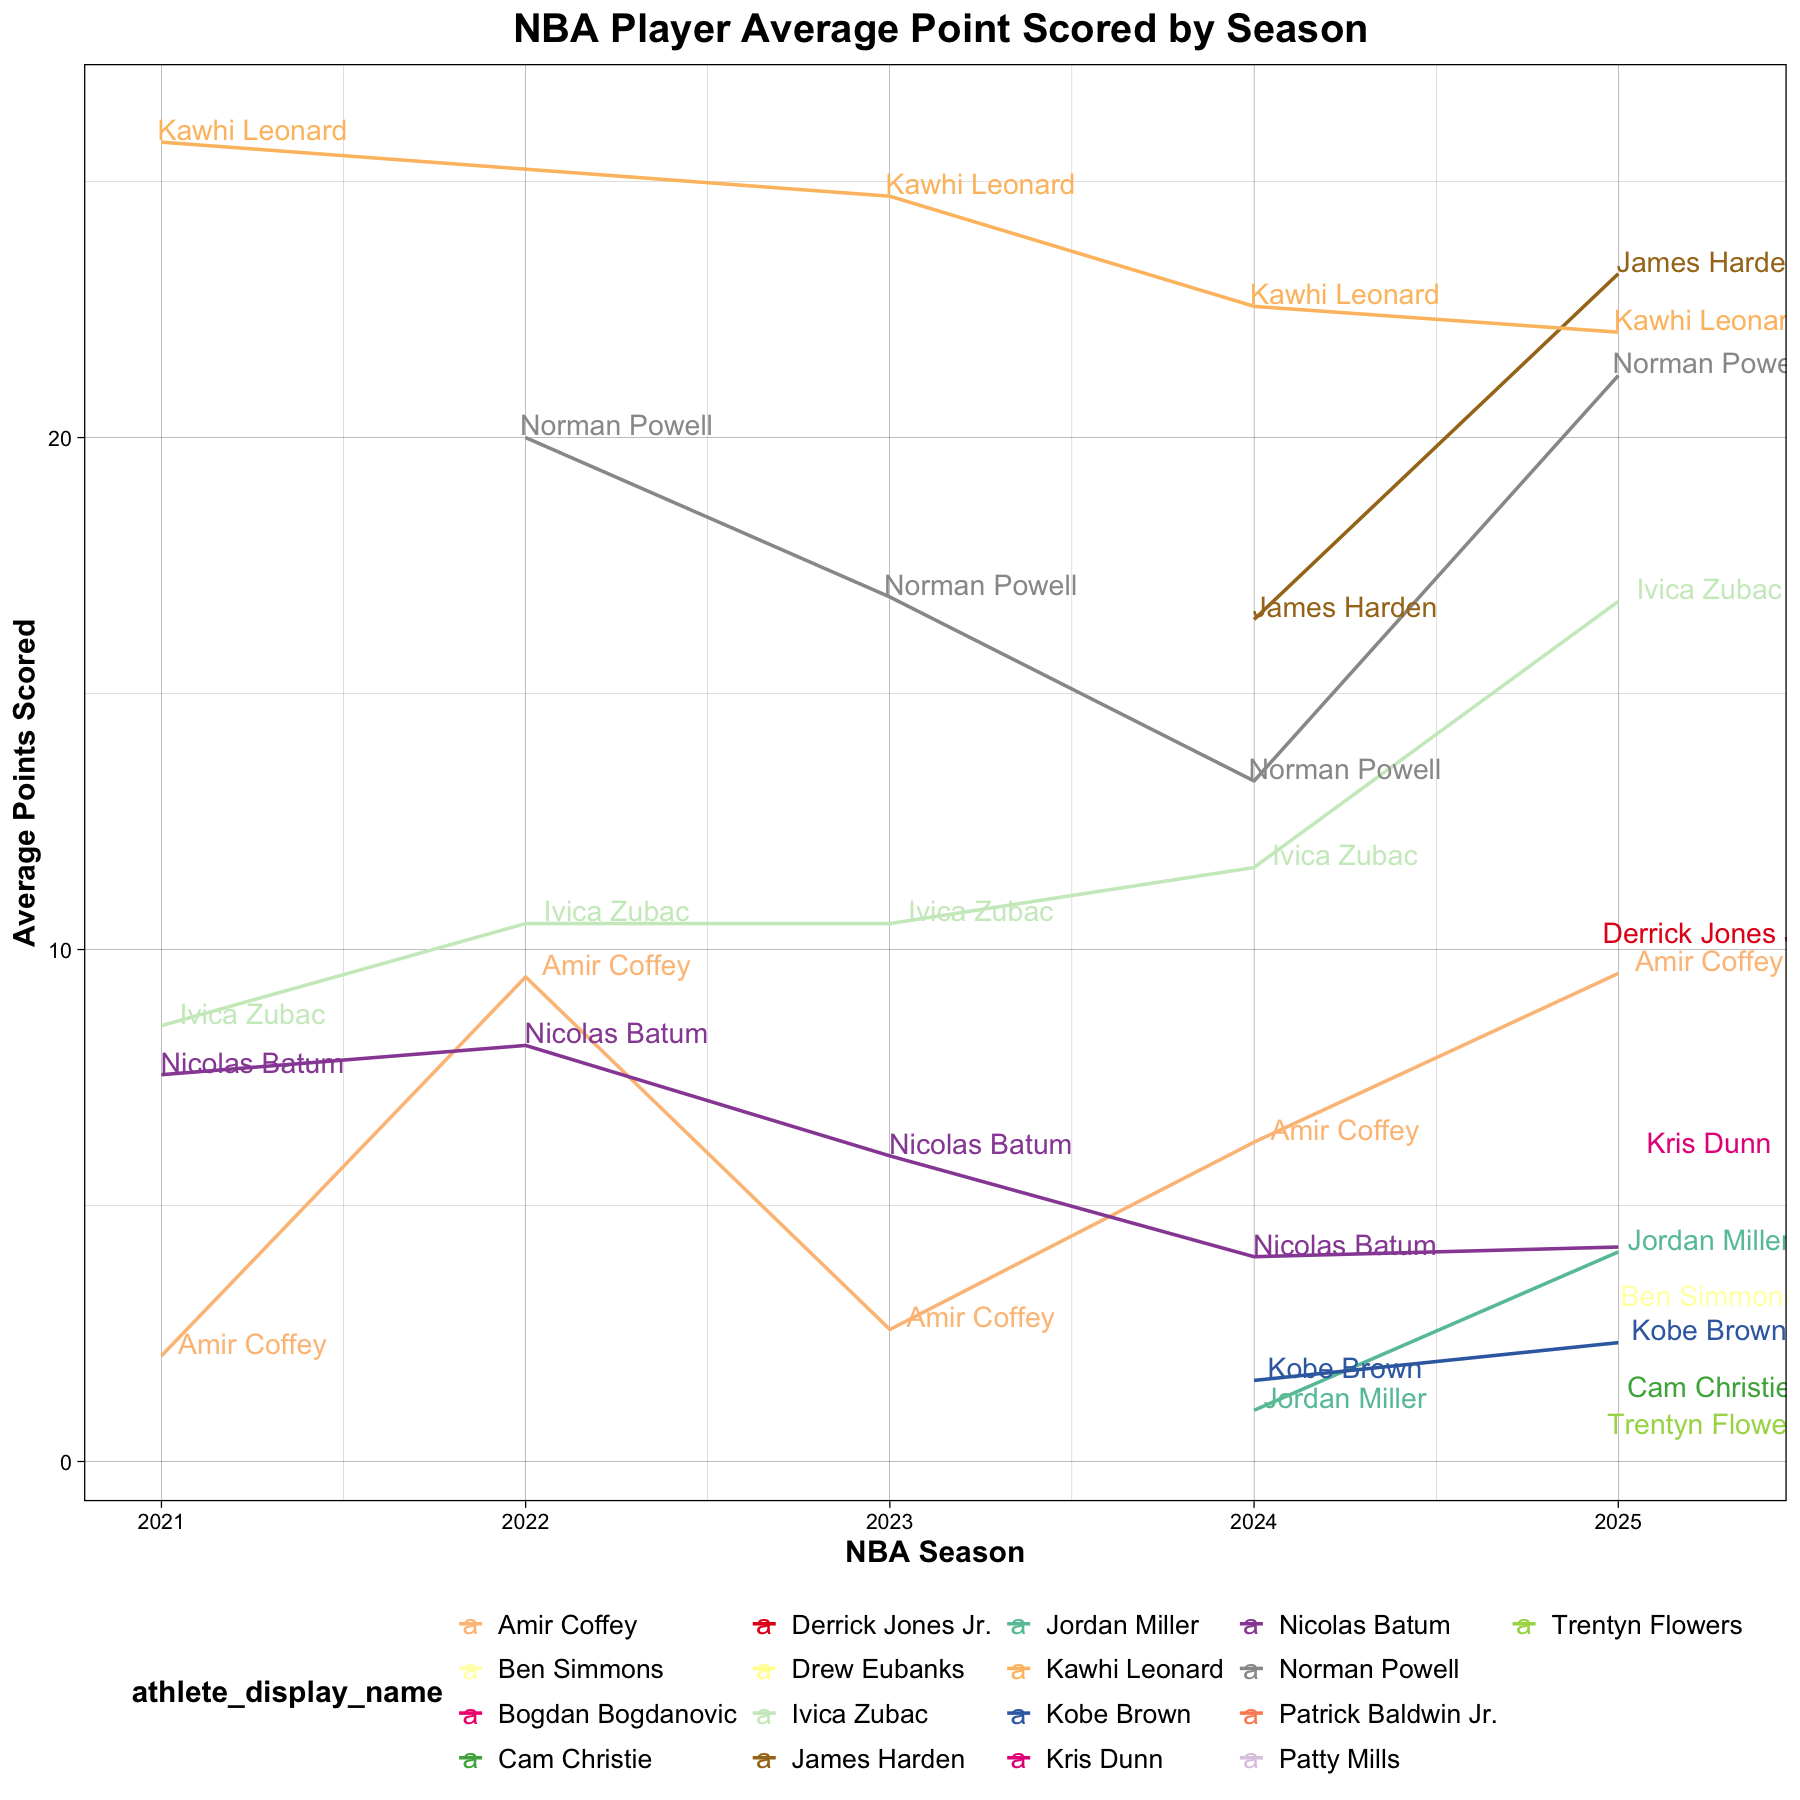

In [12]:
#Exploratory Data Analysis using train Data

# Plot average point per player over the years
player_avg_point <- trainData %>%
group_by(season,athlete_display_name) %>%
summarise(Avg_points_scored = mean(points,na.rm = TRUE), .groups = "drop")

#player_avg_point
#create color palette
library(RColorBrewer)
set.seed(13)
n <- 17
col_qual <- brewer.pal.info[brewer.pal.info$category == "qual",]
vector_col <- unlist(mapply(brewer.pal, col_qual$maxcolors, rownames(col_qual)))
color_map<- sample(vector_col,n)

options(repr.plot.width = 15, repr.plot.height = 15)

g <- ggplot(player_avg_point,aes (x = season, y = Avg_points_scored,color = athlete_display_name)) 
g + geom_line(linewidth = 1)+ theme_linedraw(base_size = 16)+ labs( title = " NBA Player Average Point Scored by Season", x = "NBA Season", y = "Average Points Scored") + theme(plot.title = element_text(hjust = 0.5,size = 24, face = "bold")) +
theme(axis.title.x = element_text(size = 18, face = "bold"), axis.title.y = element_text(size = 18, face = "bold"))+
theme(legend.text = element_text(size = 16), legend.title= element_text(size = 18, face = "bold"), legend.position = "bottom") + scale_color_manual(values = color_map) +
geom_text(label = player_avg_point$athlete_display_name, nudge_x = 0.25, nudge_y = 0.25, check_overlap = T, size = 6)


The plot above shows that for the 2025 NBA season that the top three contributors to the team scores are James Harden, Kawhi Leonard and Norman Powell while Trentyn Flowers contributed the least to the team scores. Also you will observe that Kawhi Leonard's performance in the team has been declining over the years while those of James Harden and Norman Powell have been relatively improving.

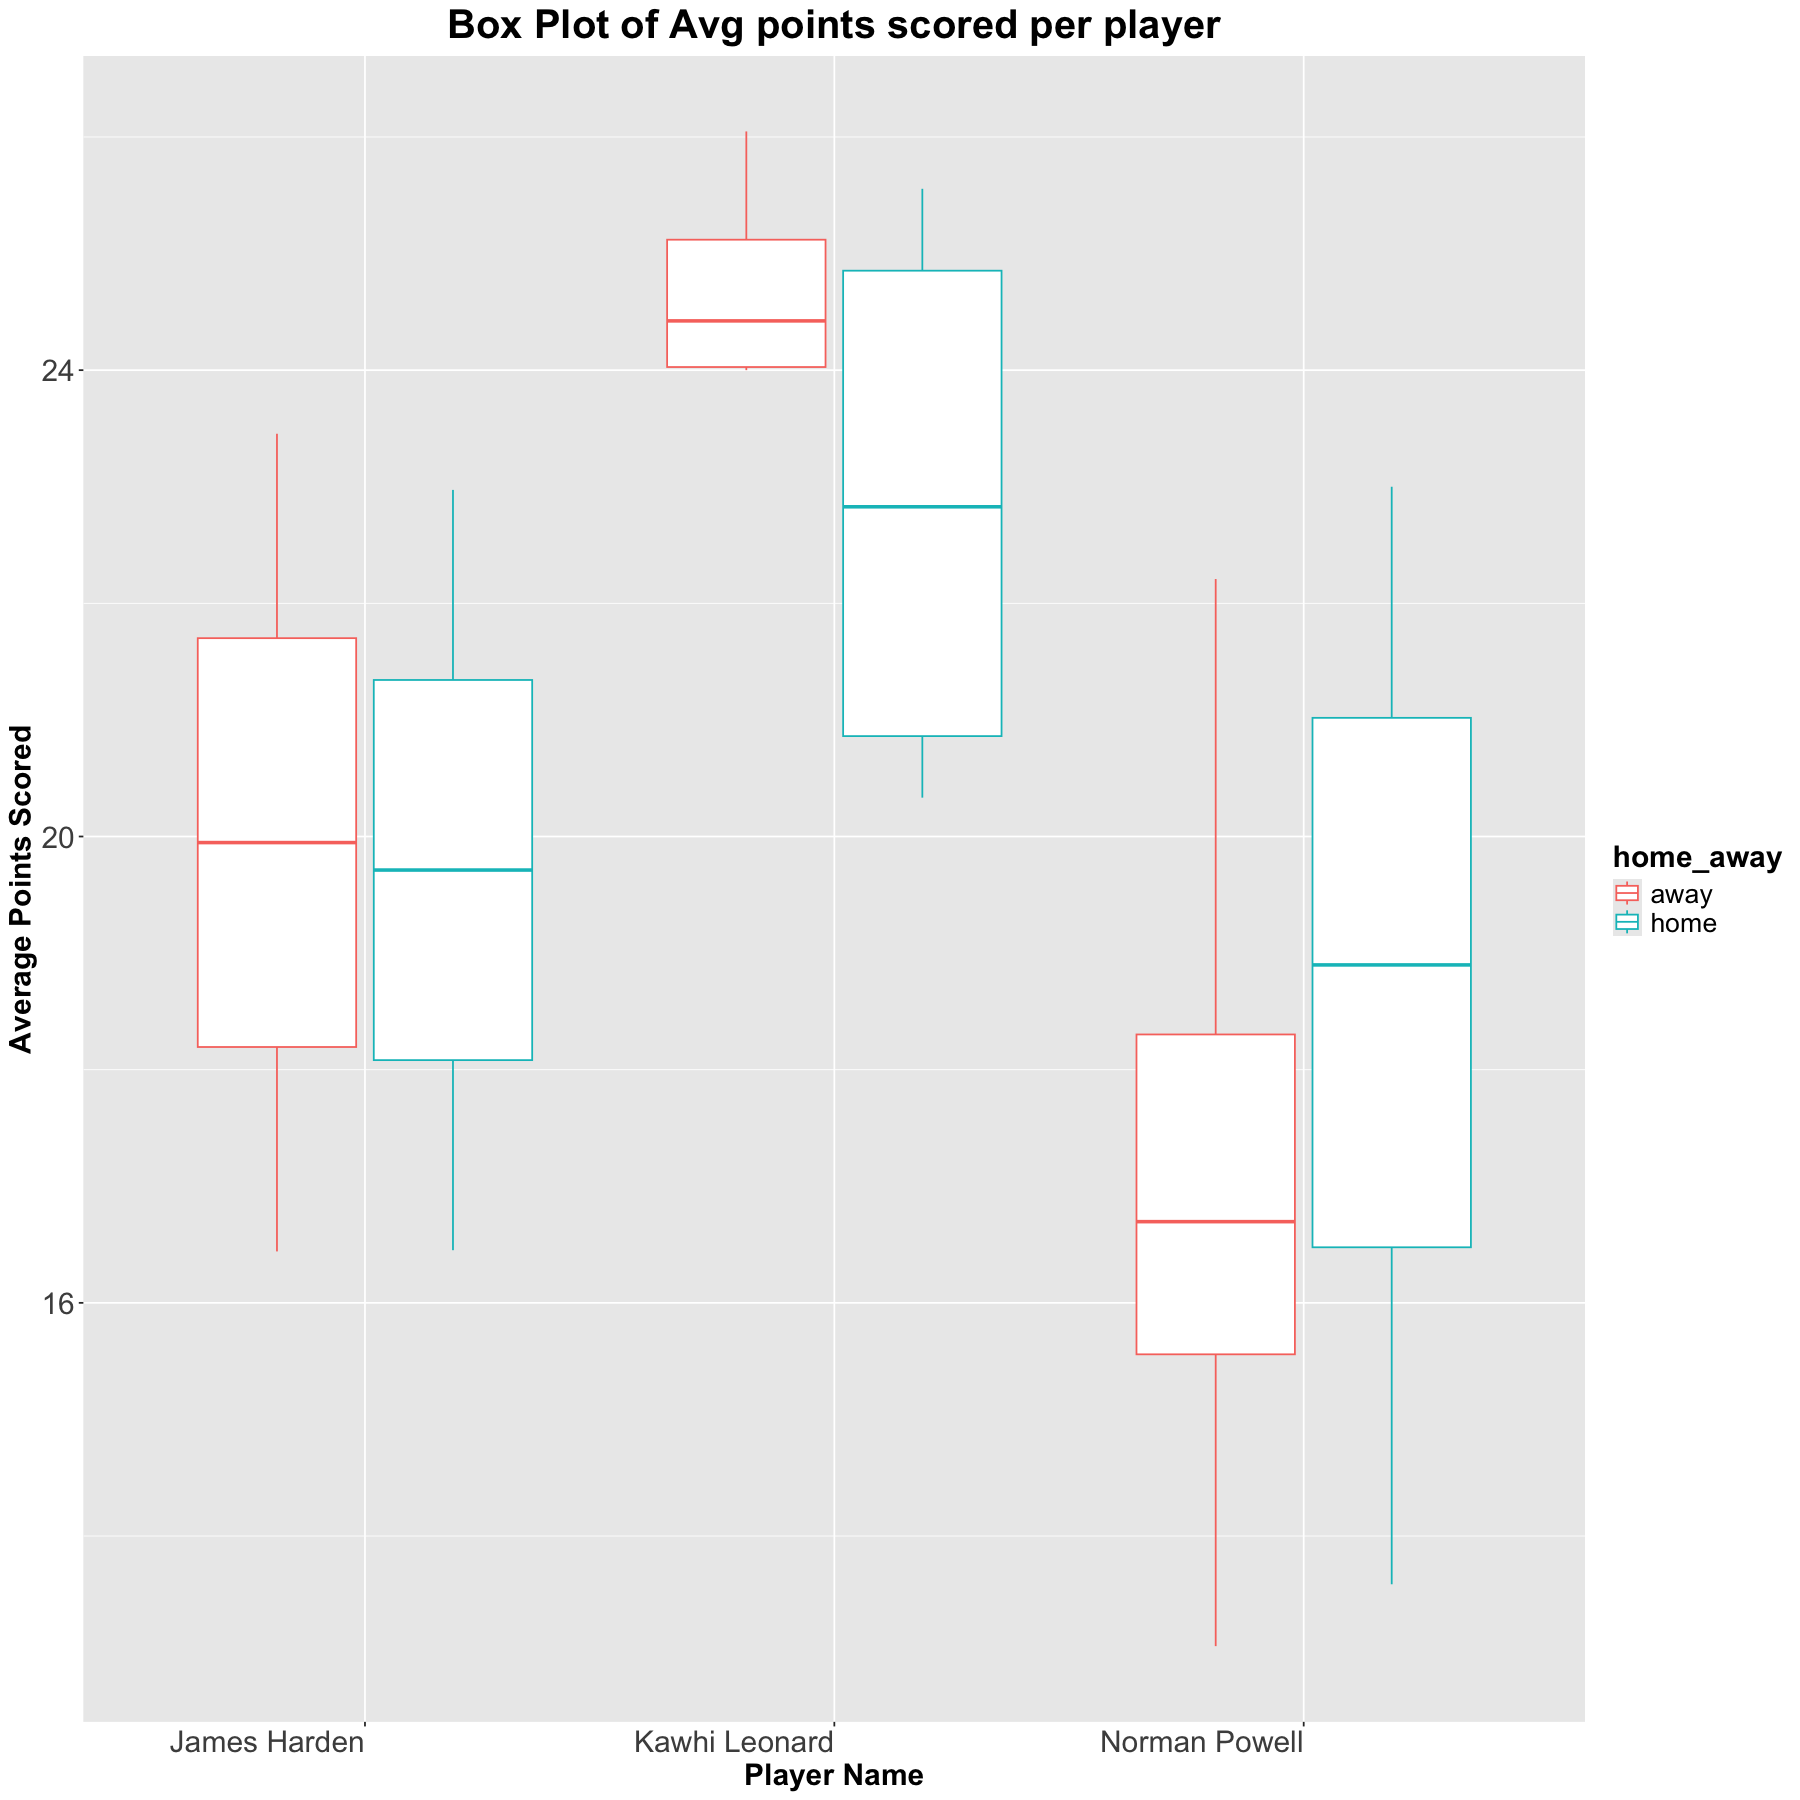

In [15]:
#Check for the effect of home advantage on the performance of the top three highest scorers and the players we are predicting for

loc_avg_point <- trainData %>%
group_by(season,athlete_display_name,home_away) %>%
summarise(Avg_points_scored = mean(points,na.rm = TRUE), .groups = "drop")
loc_avg_pointsub <- filter(loc_avg_point,  (athlete_display_name == "Kawhi Leonard" | athlete_display_name == "James Harden" | athlete_display_name == "Norman Powell"))
#loc_avg_pointsub

#Boxplot of average point scored 
g = ggplot(loc_avg_pointsub, aes(x=athlete_display_name, y=Avg_points_scored, color = home_away)) +
geom_boxplot() +  labs( title = "Box Plot of Avg points scored per player", x = "Player Name", y = "Average Points Scored") +
theme(axis.text.x = element_text(angle = 0, hjust = 1))+ theme(axis.title.x = element_text(size = 18, face = "bold"), axis.title.y = element_text(size = 18, face = "bold")) +
theme(plot.title = element_text(hjust = 0.5,size = 24, face = "bold")) + theme(axis.text = element_text(size = 18))+
theme(legend.text = element_text(size = 16), legend.title= element_text(size = 18, face = "bold"))

g

#ggsave("boxplot.png",g,width = 15, height = 15, units = c("in"))

From the boxplot , It seems that on average Kawhi Leonard performs better on away games than home games while on average Norman Powell seems to perform better at home games and there is no significant difference in performance between away games and home games for James Harden. Since each players boxplots overlap we cannot say that the average points scored by each player is statistically significantly different between home and away games.

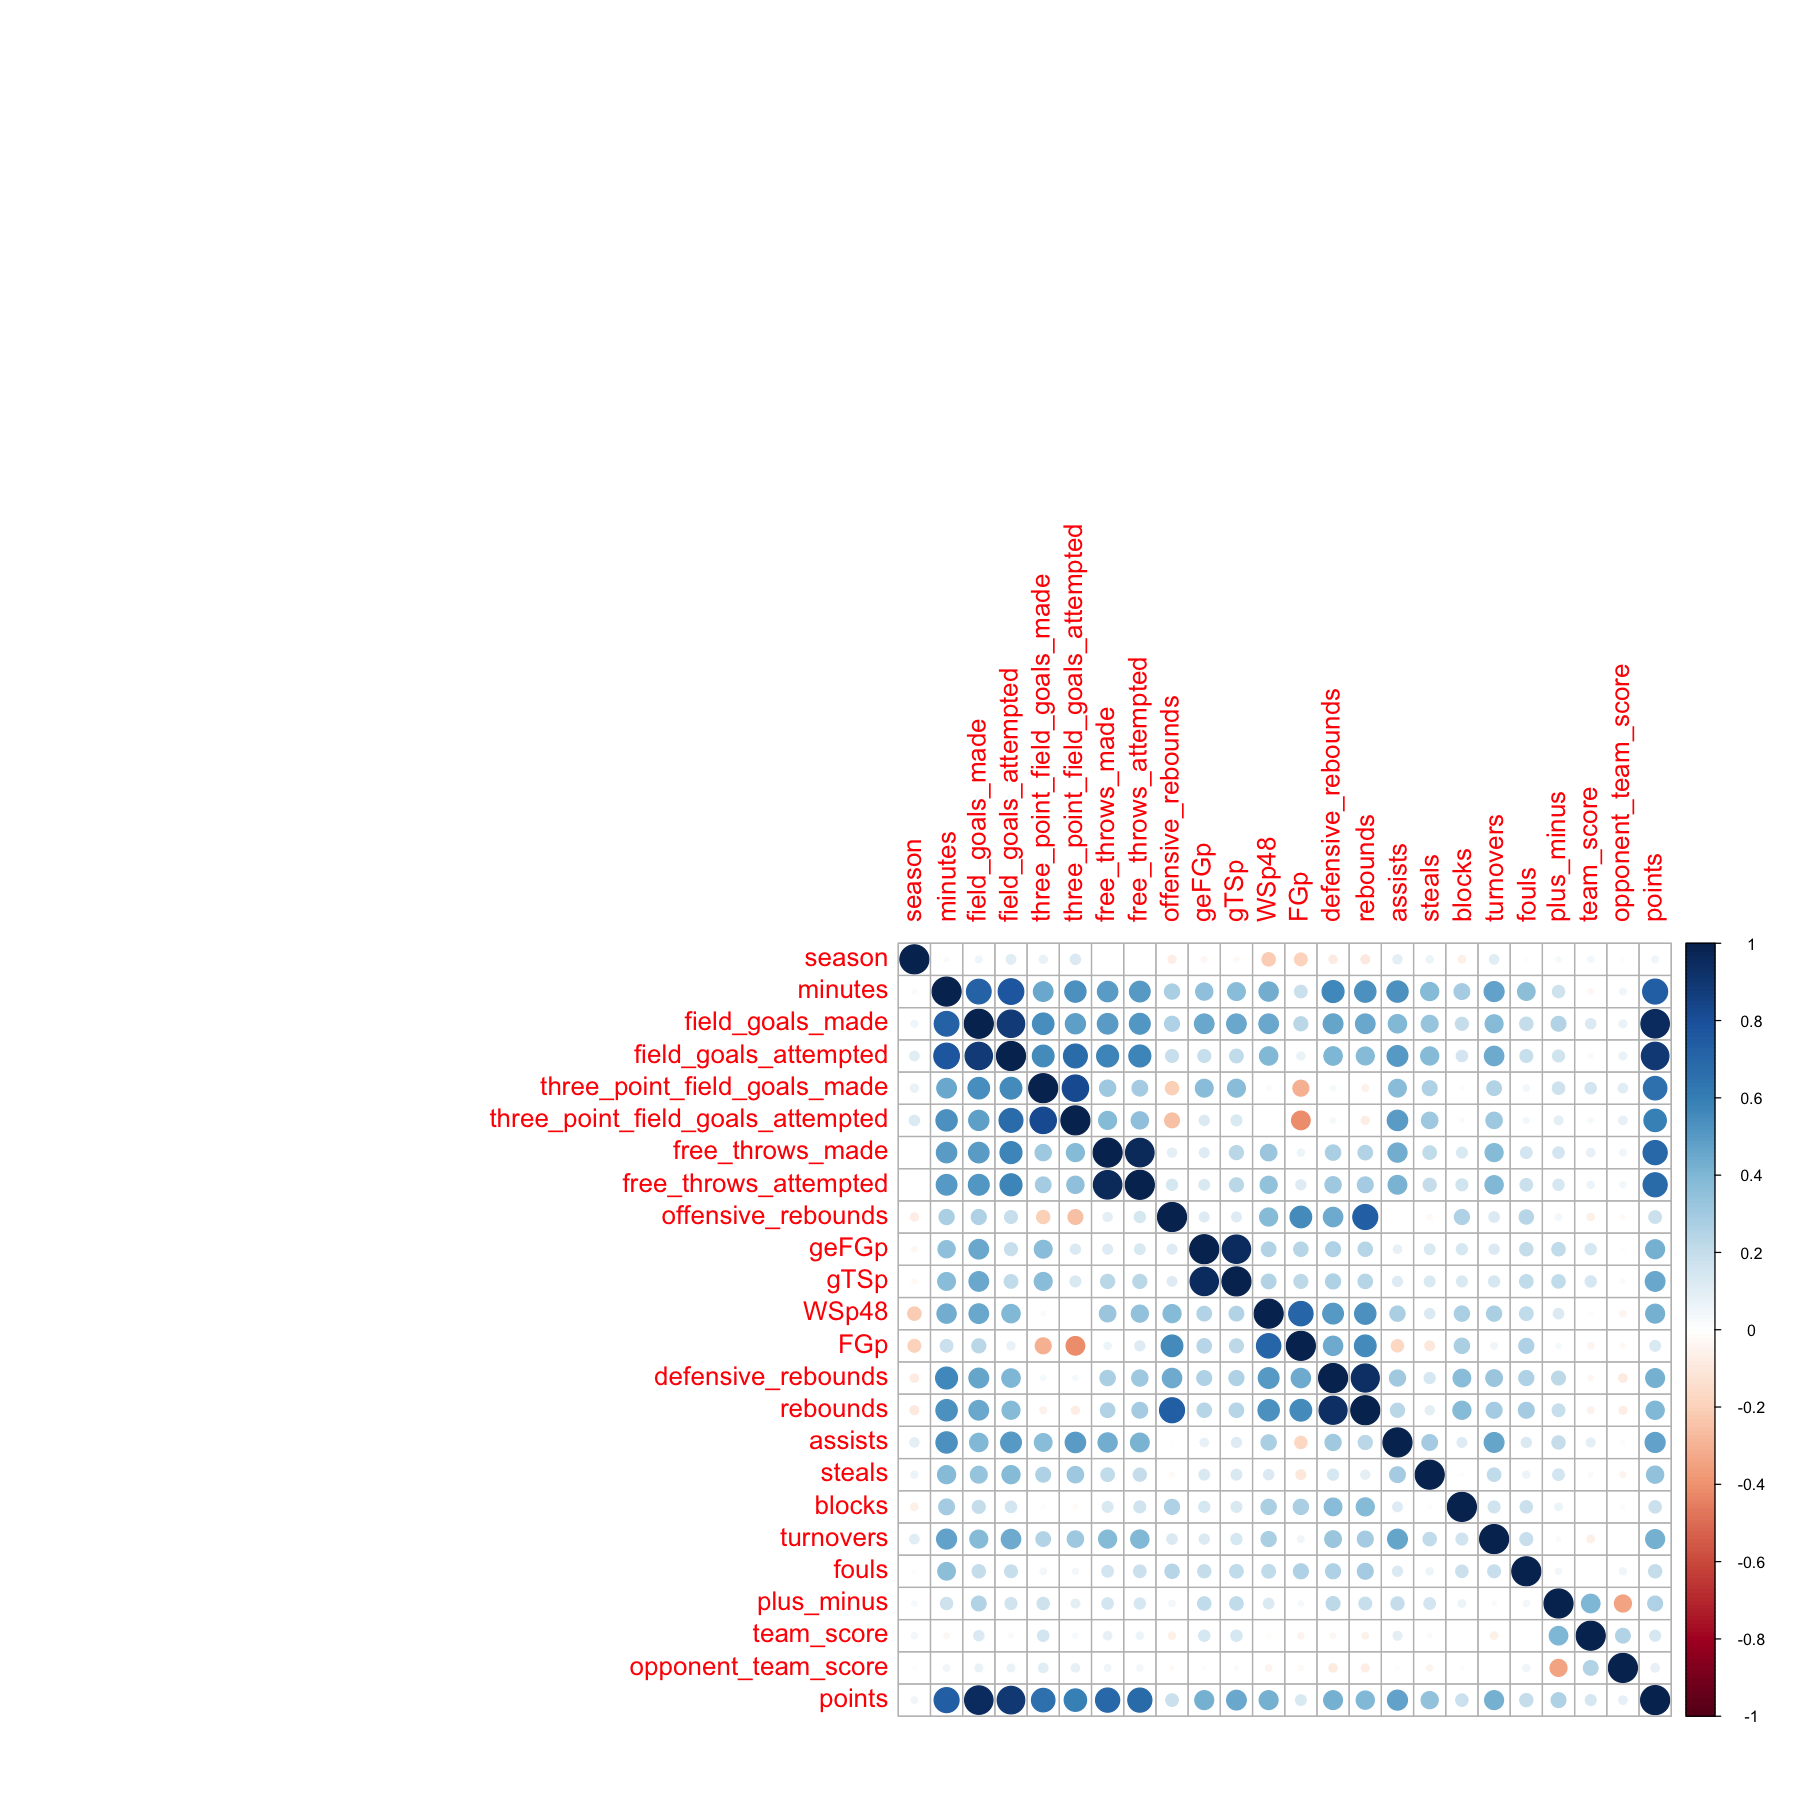

In [30]:
#check for multicollinearity
trainData_num <- subset(trainData,select = -c(game_date, athlete_display_name,home_away,team_winner,opponent_team_name))
#str(trainData_num)
corrplot(cor(trainData_num), method = "circle",tl.cex=1.3)


Based on the correlation plot above, we have significant multicollinearity among our dataset predictors. For example field_goals_made is highly correlated with field_goals_attempted which is not suprising since goals are made from attempts. Also gEFGp is highly correlated with gTSp. The multicollinearity problem observed suggest that we should not use all the predictors in building the Poisson model. I plan to address the multicollinearity issues with variable selection and regularized regression approaches specifically Ridge Regression.

### Model Building

In [33]:
#Build full poisson model using train dataset and all predictors
set.seed(123)
trainData_adj <- subset(trainData,select = -c(game_date, rebounds))

full_model <- glm(points~., data = trainData_adj, family = "poisson")
summary(full_model)


Call:
glm(formula = points ~ ., family = "poisson", data = trainData_adj)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                              5.5075498 14.1300982   0.390 0.696703
season                                  -0.0032251  0.0069778  -0.462 0.643946
athlete_display_nameBen Simmons         -0.2884576  0.1419654  -2.032 0.042165
athlete_display_nameBogdan Bogdanovic    0.0472511  0.0702001   0.673 0.500889
athlete_display_nameCam Christie        -0.0765466  0.3214140  -0.238 0.811760
athlete_display_nameDerrick Jones Jr.    0.0018644  0.0669538   0.028 0.977785
athlete_display_nameDrew Eubanks        -0.5018099  0.1424817  -3.522 0.000428
athlete_display_nameIvica Zubac         -0.4135937  0.1247759  -3.315 0.000917
athlete_display_nameJames Harden         0.1984374  0.0589904   3.364 0.000769
athlete_display_nameJordan Miller       -0.0121925  0.0926958  -0.132 0.895354
athlete_display_nameKawhi Leonard       -

#### Model Interpretation

Based on the output of the full model we can infer some of the following:

1. For every additional percentage increase in a LAC team player Average season field goal percentage(FGp), the log expected total points scored by that player increases 2.9888960, provided all other predictors are kept constant.
2. For every additional percentage increase in a LAC team player true shooting percentage in a game(gTSp), the log expected total points scored by that player increases by 1.643, provided all other predictors are kept constant.
3. For every additional minute played by a LAC team player in a game, the log expected total points scored by that player increases by 0.01451, provided all other predictors are kept constant.
4. The rate ratio of the total points scored by James Harden when compared to Amir Coffey is 1.219 or on average the total points scored increases by 22% when the player is James Harden when compared to Amir Coffey keeping all other predictors constant.
5. The rate ratio of the total points scored by Norman Powell when compared to Amir Coffey is 1.123 or on average the total points scored increases by 12% when the player is Norman Powell when compared to Amir Coffey keeping all other predictors constant.
6. The rate ratio of the total points scored by Kawhi Leonard when compared to Amir Coffey is 0.913 or on average the total points scored decreases by 9% when the player is Kawhi Leonard when compared to Amir Coffey keeping all other predictors constant.
7. For every additional three point field goal made by a LAC team player in a game, the log expected total points scored by that player decreases by 0.00916, keeping all other predictors constant
8. On average the total points scored by a LAC player decreases by 6% when the team is the Denver Nuggets when compared to when the team is the 76ers keeping all other predictors constant.
9. Not all the predictors are statistically significant.

Points 6 and 7 seems contradictory to what we will expect, from exploratory data analysis we know that on average Kawhi Leonard scores more points that Amir Coffey and also we expect a positive linear relationship between three points field goal made and the player's total points in a game instead we see a negative relationship and surprisingly a positive relationship between the three point field goals attempted and the player's total points. We know from our correlation plots that there is a high correlation between three point field goal made and three point field goals attempted which will suggest that the contradictions we are observing may be because of multicollinearity. Based on this observation, it seems that multicollinearity is affecting the sign of our coefficients and it will need to be addressed to get a reliably predictive model. Next I will evaluate the full model for goodness of fit using the Deviance and Pearson residuals.

### Model Fit

In [36]:
#Goodness of fit for full model

#Deviance Test for GOF for the full model
pdev_fullmodel <- 1-pchisq(full_model$deviance,full_model$df.residual)

#Pearson residual test for GOF for all models
full_modelresid <- resid(full_model, type = "pearson")
ppear_fullmodel <- 1-pchisq(sum(full_modelresid^2), full_model$df.residual)

GOF_pval = data.frame( 
    "Type of Model" = c(
        "Full Model"
        
    ),
    "Deviance P_value" = c(pdev_fullmodel
              
              
              ),
    "Pearson P_value" = c(ppear_fullmodel
              
              ))

print(GOF_pval)


  Type.of.Model Deviance.P_value Pearson.P_value
1    Full Model                1               1


Since the p-values of both the deviance and pearson residuals are large, we fail to reject the null hypothesis and conclude that the full model is a good fit. Next I will test the full model for overdispersion.

In [39]:
# Test for overdispersion in full model
overdisp_fullmodel <- full_model$deviance/full_model$df.residual
print(paste("The estimated dispersion parameter for the full model is:",overdisp_fullmodel, sep = " "))

[1] "The estimated dispersion parameter for the full model is: 0.787294029193347"


Since the full model's dispersion parameter < 2, the full model is not an overdispersed model. Next I will test to determine if the full model has explanatory powers.

In [122]:
# Test of Overall Regression of full model
gstat <- full_model$null.deviance - deviance(full_model)
p_valueover<- 1-pchisq(gstat,length(coef(full_model))-1)
print(paste("The p-value for the test of overall regression for the full model is :",p_valueover, sep = " "))

[1] "The p-value for the test of overall regression for the full model is : 0"


Since the p-value for the test for overall regression is zero, we reject the null hypothesis  that all regression coefficients except the intercept are zero and thus conclude that at least one of the predicting variables in the full model is statistically significant and that the full model has statistically significant power in explaining the total points scored by a LAC team player. Next I will address multicollinearity in our full model with variable selection and regularized regression.

### Variable Selection

The following variable selection and regularized regression approaches were done 

1. Stepwise forward stepwise regression with AIC
2. Stepwise forward stepwise regression with BIC
3. Stepwise backward stepwise regression with AIC
4. Stepwise backward stepwise regression with BIC
5. Stepwise forward backward stepwise regression with AIC
6. Stepwise forward backward stepwise regression with BIC
7. Lasso Regression
8. Elastic Net Regression
9. Ridge Regression

Using the test dataset, the prediction accuracy of each model was determined and the model with the lowest Precision Measure will be selected to be the best Poisson model. 

In [46]:
#Variable selection using train dataset
set.seed(123)
#Stepwise forward stepwise regression with AIC
null_model = glm(points~ 1, data = trainData_adj, family = "poisson")
n = nrow(trainData_adj)

stepwise_forwardAIC <- step(null_model, scope = list(lower = null_model, upper = full_model), direction = "forward", trace = FALSE)

summary(stepwise_forwardAIC)



Call:
glm(formula = points ~ field_goals_made + athlete_display_name + 
    gTSp + field_goals_attempted + minutes + free_throws_attempted + 
    FGp + three_point_field_goals_attempted + offensive_rebounds + 
    plus_minus + defensive_rebounds + turnovers, family = "poisson", 
    data = trainData_adj)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -1.0541714  0.2875792  -3.666 0.000247
field_goals_made                         0.0203261  0.0060698   3.349 0.000812
athlete_display_nameBen Simmons         -0.3384839  0.1397870  -2.421 0.015460
athlete_display_nameBogdan Bogdanovic    0.0308367  0.0668371   0.461 0.644532
athlete_display_nameCam Christie        -0.1278104  0.3202062  -0.399 0.689782
athlete_display_nameDerrick Jones Jr.    0.0087483  0.0635158   0.138 0.890450
athlete_display_nameDrew Eubanks        -0.5242402  0.1396181  -3.755 0.000173
athlete_display_nameIvica Zubac         -0.385

Stepwise forward regression using AIC selected 27 predictors out of the 68 predictors in the full model. It selected all the three top LAC scorers and also addressed multicollinearity by selecting free_throws_attempted, three_point_field_goals_attempted and gTSp and not selecting the predictors that highly correlate with these selected predictors which are free_throws_made, three_point_field_goals_made and geFGp. Interestingly It still selected two highly correlated predictors, field_goals_made and field_goals_attempted. Most of the predictors selected are statistically significant.

In [49]:
#Stepwise forward stepwise regression with BIC
set.seed(123)
stepwise_forwardBIC <- step(null_model, scope = list(lower = null_model, upper = full_model), direction = "forward", k = log(n), trace = FALSE)
summary(stepwise_forwardBIC)


Call:
glm(formula = points ~ field_goals_made + minutes + gTSp + field_goals_attempted + 
    athlete_display_name + free_throws_attempted + FGp, family = "poisson", 
    data = trainData_adj)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -1.0997720  0.2848678  -3.861 0.000113
field_goals_made                         0.0202753  0.0059103   3.431 0.000602
minutes                                  0.0152935  0.0014866  10.288  < 2e-16
gTSp                                     1.4260797  0.0504308  28.278  < 2e-16
field_goals_attempted                    0.0649786  0.0038763  16.763  < 2e-16
athlete_display_nameBen Simmons         -0.3482915  0.1392939  -2.500 0.012405
athlete_display_nameBogdan Bogdanovic    0.0341014  0.0663768   0.514 0.607424
athlete_display_nameCam Christie        -0.1040694  0.3199760  -0.325 0.744999
athlete_display_nameDerrick Jones Jr.   -0.0001102  0.0625473  -0.002 0.998594
a

Stepwise forward regression using BIC selected 22 predictors(5 fewer than Stepwise forward regression using AIC). It also selected all the three LAC top scorers and also addressed multicollinearity. It also selected two highly correlated predictors field_goals_made and field_goals_attempted and most of the selected predictors are statistically significant.

In [52]:
#Stepwise backward stepwise regression with AIC
set.seed(123)
stepwise_backAIC <- step(full_model, scope = list(lower = null_model, upper = full_model), direction = "backward", trace = FALSE)
summary(stepwise_backAIC)


Call:
glm(formula = points ~ athlete_display_name + minutes + field_goals_made + 
    field_goals_attempted + three_point_field_goals_attempted + 
    free_throws_made + free_throws_attempted + offensive_rebounds + 
    geFGp + gTSp + FGp + defensive_rebounds + turnovers + plus_minus, 
    family = "poisson", data = trainData_adj)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -1.0995482  0.2885966  -3.810 0.000139
athlete_display_nameBen Simmons         -0.3286453  0.1399242  -2.349 0.018837
athlete_display_nameBogdan Bogdanovic    0.0336375  0.0669004   0.503 0.615105
athlete_display_nameCam Christie        -0.1271254  0.3201913  -0.397 0.691346
athlete_display_nameDerrick Jones Jr.    0.0085762  0.0637377   0.135 0.892964
athlete_display_nameDrew Eubanks        -0.5347380  0.1397503  -3.826 0.000130
athlete_display_nameIvica Zubac         -0.3943039  0.1210185  -3.258 0.001121
athlete_display_nam

Stepwise backward regression using AIC selected 2 more predictors(free_throw_made and geFGp) than the predictors selected by Stepwise forward regression using AIC. The additional predictors selected have a high correlation with other predictors selected suggesting that Stepwise backward regression using AIC may be doing a poorer job of addressing multicollinearity.

In [55]:
#Stepwise backward stepwise regression with BIC
set.seed(123)
stepwise_backBIC <- step(full_model, scope = list(lower = null_model, upper = full_model), direction = "backward", k = log(n),trace = FALSE)
summary(stepwise_backBIC)


Call:
glm(formula = points ~ athlete_display_name + minutes + field_goals_made + 
    field_goals_attempted + free_throws_attempted + gTSp + FGp, 
    family = "poisson", data = trainData_adj)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -1.0997720  0.2848678  -3.861 0.000113
athlete_display_nameBen Simmons         -0.3482915  0.1392939  -2.500 0.012405
athlete_display_nameBogdan Bogdanovic    0.0341014  0.0663768   0.514 0.607424
athlete_display_nameCam Christie        -0.1040694  0.3199760  -0.325 0.744999
athlete_display_nameDerrick Jones Jr.   -0.0001102  0.0625473  -0.002 0.998594
athlete_display_nameDrew Eubanks        -0.5336537  0.1382421  -3.860 0.000113
athlete_display_nameIvica Zubac         -0.3965357  0.1146004  -3.460 0.000540
athlete_display_nameJames Harden         0.2026375  0.0434221   4.667 3.06e-06
athlete_display_nameJordan Miller       -0.0093766  0.0909434  -0.103 0.917881
a

Stepwise backward regression using BIC selected the same predictors as Stepwise forward regression using BIC

In [58]:
#Stepwise forward backward stepwise regression with AIC
set.seed(123)
stepwise_forward_backAIC<- step(null_model, scope = list(lower = null_model, upper = full_model), direction = "both", trace = FALSE)
summary(stepwise_forward_backAIC)


Call:
glm(formula = points ~ field_goals_made + athlete_display_name + 
    gTSp + field_goals_attempted + minutes + free_throws_attempted + 
    FGp + three_point_field_goals_attempted + offensive_rebounds + 
    plus_minus + defensive_rebounds + turnovers, family = "poisson", 
    data = trainData_adj)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -1.0541714  0.2875792  -3.666 0.000247
field_goals_made                         0.0203261  0.0060698   3.349 0.000812
athlete_display_nameBen Simmons         -0.3384839  0.1397870  -2.421 0.015460
athlete_display_nameBogdan Bogdanovic    0.0308367  0.0668371   0.461 0.644532
athlete_display_nameCam Christie        -0.1278104  0.3202062  -0.399 0.689782
athlete_display_nameDerrick Jones Jr.    0.0087483  0.0635158   0.138 0.890450
athlete_display_nameDrew Eubanks        -0.5242402  0.1396181  -3.755 0.000173
athlete_display_nameIvica Zubac         -0.385

Stepwise forward backward regression using AIC selected the same predictors as Stepwise forward regression using AIC

In [61]:
#Stepwise forward backward stepwise regression with BIC
set.seed(123)
stepwise_forward_backBIC<- step(null_model, scope = list(lower = null_model, upper = full_model), direction = "both", trace = FALSE, k= log(n))
summary(stepwise_forward_backBIC)


Call:
glm(formula = points ~ field_goals_made + minutes + gTSp + field_goals_attempted + 
    athlete_display_name + free_throws_attempted + FGp, family = "poisson", 
    data = trainData_adj)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -1.0997720  0.2848678  -3.861 0.000113
field_goals_made                         0.0202753  0.0059103   3.431 0.000602
minutes                                  0.0152935  0.0014866  10.288  < 2e-16
gTSp                                     1.4260797  0.0504308  28.278  < 2e-16
field_goals_attempted                    0.0649786  0.0038763  16.763  < 2e-16
athlete_display_nameBen Simmons         -0.3482915  0.1392939  -2.500 0.012405
athlete_display_nameBogdan Bogdanovic    0.0341014  0.0663768   0.514 0.607424
athlete_display_nameCam Christie        -0.1040694  0.3199760  -0.325 0.744999
athlete_display_nameDerrick Jones Jr.   -0.0001102  0.0625473  -0.002 0.998594
a

Stepwise forward backward regression using BIC selected the same predictors as Stepwise forward regression using BIC

In [72]:
#Summary of stepwise regression
aic_forward_modelAIC <- AIC(stepwise_forwardAIC)
bic_forward_modelAIC <- BIC(stepwise_forwardAIC)
aic_forward_modelBIC <- AIC(stepwise_forwardBIC)
bic_forward_modelBIC <- BIC(stepwise_forwardBIC)
aic_back_modelAIC <- AIC(stepwise_backAIC)
bic_back_modelAIC <- BIC(stepwise_backAIC)
aic_back_modelBIC <- AIC(stepwise_backBIC)
bic_back_modelBIC <- BIC(stepwise_backBIC)
aic_forw_back_modelAIC <- AIC(stepwise_forward_backAIC)
bic_forw_back_modelAIC <- BIC(stepwise_forward_backAIC)
aic_forw_back_modelBIC <- AIC(stepwise_forward_backBIC)
bic_forw_back_modelBIC <- BIC(stepwise_forward_backBIC)
aic_fullmodel <- AIC(full_model)
bic_fullmodel <- BIC(full_model)
#Create results dataframe
stepwise_summary <- data.frame( 
    "Type of Model" = c(
        "Full model",
        "Stepwise Forward using AIC",
        "Stepwise Forward using BIC",
        "Stepwise Backward using AIC",
        "Stepwise Backward using BIC",
        "Stepwise Forward-Backward using AIC",
        "Stepwise Forward-Backward using BIC"),
    "AIC" = c(aic_fullmodel,
              aic_forward_modelAIC,
              aic_forward_modelBIC,
              aic_back_modelAIC,
              aic_back_modelBIC,
              aic_forw_back_modelAIC,
              aic_forw_back_modelBIC),
    "BIC" = c(bic_fullmodel,
              bic_forward_modelAIC,
              bic_forward_modelBIC,
              bic_back_modelAIC,
              bic_back_modelBIC,
              bic_forw_back_modelAIC,
              bic_forw_back_modelBIC))

print(stepwise_summary)


                        Type.of.Model      AIC      BIC
1                          Full model 7410.252 7783.189
2          Stepwise Forward using AIC 7371.309 7522.646
3          Stepwise Forward using BIC 7383.738 7508.050
4         Stepwise Backward using AIC 7371.902 7534.048
5         Stepwise Backward using BIC 7383.738 7508.050
6 Stepwise Forward-Backward using AIC 7371.309 7522.646
7 Stepwise Forward-Backward using BIC 7383.738 7508.050


Based on the summary table above, all the stepwise models have both lower AIC and BIC than the full model indicating that they are all better models than the full model. Using AIC criteria, the best stepwise model will be one of the stepwise forward models using AIC and if the BIC criteria is used then the best stepwise model will be one of stepwise models using BIC. Based on the handling of multicollinearity, I lean towards selecting the Stepwise Forward using AIC as the best stepwise regression model. Next I will compare this model to the full model to statistically determine if the Stepwise Forward using AIC has similar explanatory powers as the full model.

In [75]:
#Statistical Inference on the selected stepwise regression model

#Test for Subset of Coefficients 
anova(stepwise_forwardAIC, full_model, test = "Chisq")



,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1616,1283.045,NA,NA,NA
2,1575,1239.988,41,43.05644,0.3833055


The p-value of the anova test is large, indicating that we fail to reject the null hypothesis and that the coefficients of the predictors not selected are possibly zero. Thus we can conclude that the Stepwise Forward Regression using AIC model has similar explanatory powers as the full model and therefore we prefer the Stepwise Forward Regression using AIC model since it has less predictors. Next I will look at the regularized regression approaches.

In [78]:
# LASSO Regression 
#set seed
set.seed(123)
x <- model.matrix(points ~., trainData_adj)[,-1]

y <- trainData_adj$points
# 10fold CV to find optimal lambda
lasso_cv <- cv.glmnet(x,y,family = "poisson", alpha = 1, nfolds = 10)
opt_lambdalass <- lasso_cv$lambda.min
print(paste("The optimal lambda value for the lasso model is", opt_lambdalass, sep = " "))

[1] "The optimal lambda value for the lasso model is 0.0142269895367908"


In [80]:
#fit lasso model with 100 values for lambda
set.seed(123)
lasso_model <- glmnet(x,y,family = "poisson", alpha = 1, nlambda = 100)
#Extract coefficients at the optimal lambda
coef(lasso_model, s = opt_lambdalass)


69 x 1 sparse Matrix of class "dgCMatrix"
                                                   s1
(Intercept)                              3.2622948518
season                                  -0.0017711016
athlete_display_nameBen Simmons         -0.2816724509
athlete_display_nameBogdan Bogdanovic    0.0614013849
athlete_display_nameCam Christie        -0.1695514120
athlete_display_nameDerrick Jones Jr.    0.1161577428
athlete_display_nameDrew Eubanks        -0.2924967879
athlete_display_nameIvica Zubac         -0.1031237417
athlete_display_nameJames Harden         0.1283720311
athlete_display_nameJordan Miller        .           
athlete_display_nameKawhi Leonard        .           
athlete_display_nameKobe Brown          -0.5130639152
athlete_display_nameKris Dunn           -0.0394510035
athlete_display_nameNicolas Batum       -0.1023981659
athlete_display_nameNorman Powell        0.1641622407
athlete_display_namePatrick Baldwin Jr. -1.3646175356
athlete_display_namePatty Mills         

Lasso regression shrunk 8 coefficients to zero and selected 60 predictors, much more predictors than were selected by the stepwise regression models. Surprisingly it shrunk the coefficient of Kawhi Leonard(a top scorer) to zero, this is likely a result of a known issue with LASSO where when a group of variables are highly correlated, LASSO tends to just select only one of the variable from the group without caring whether the variable selected is the most logical one to select. 

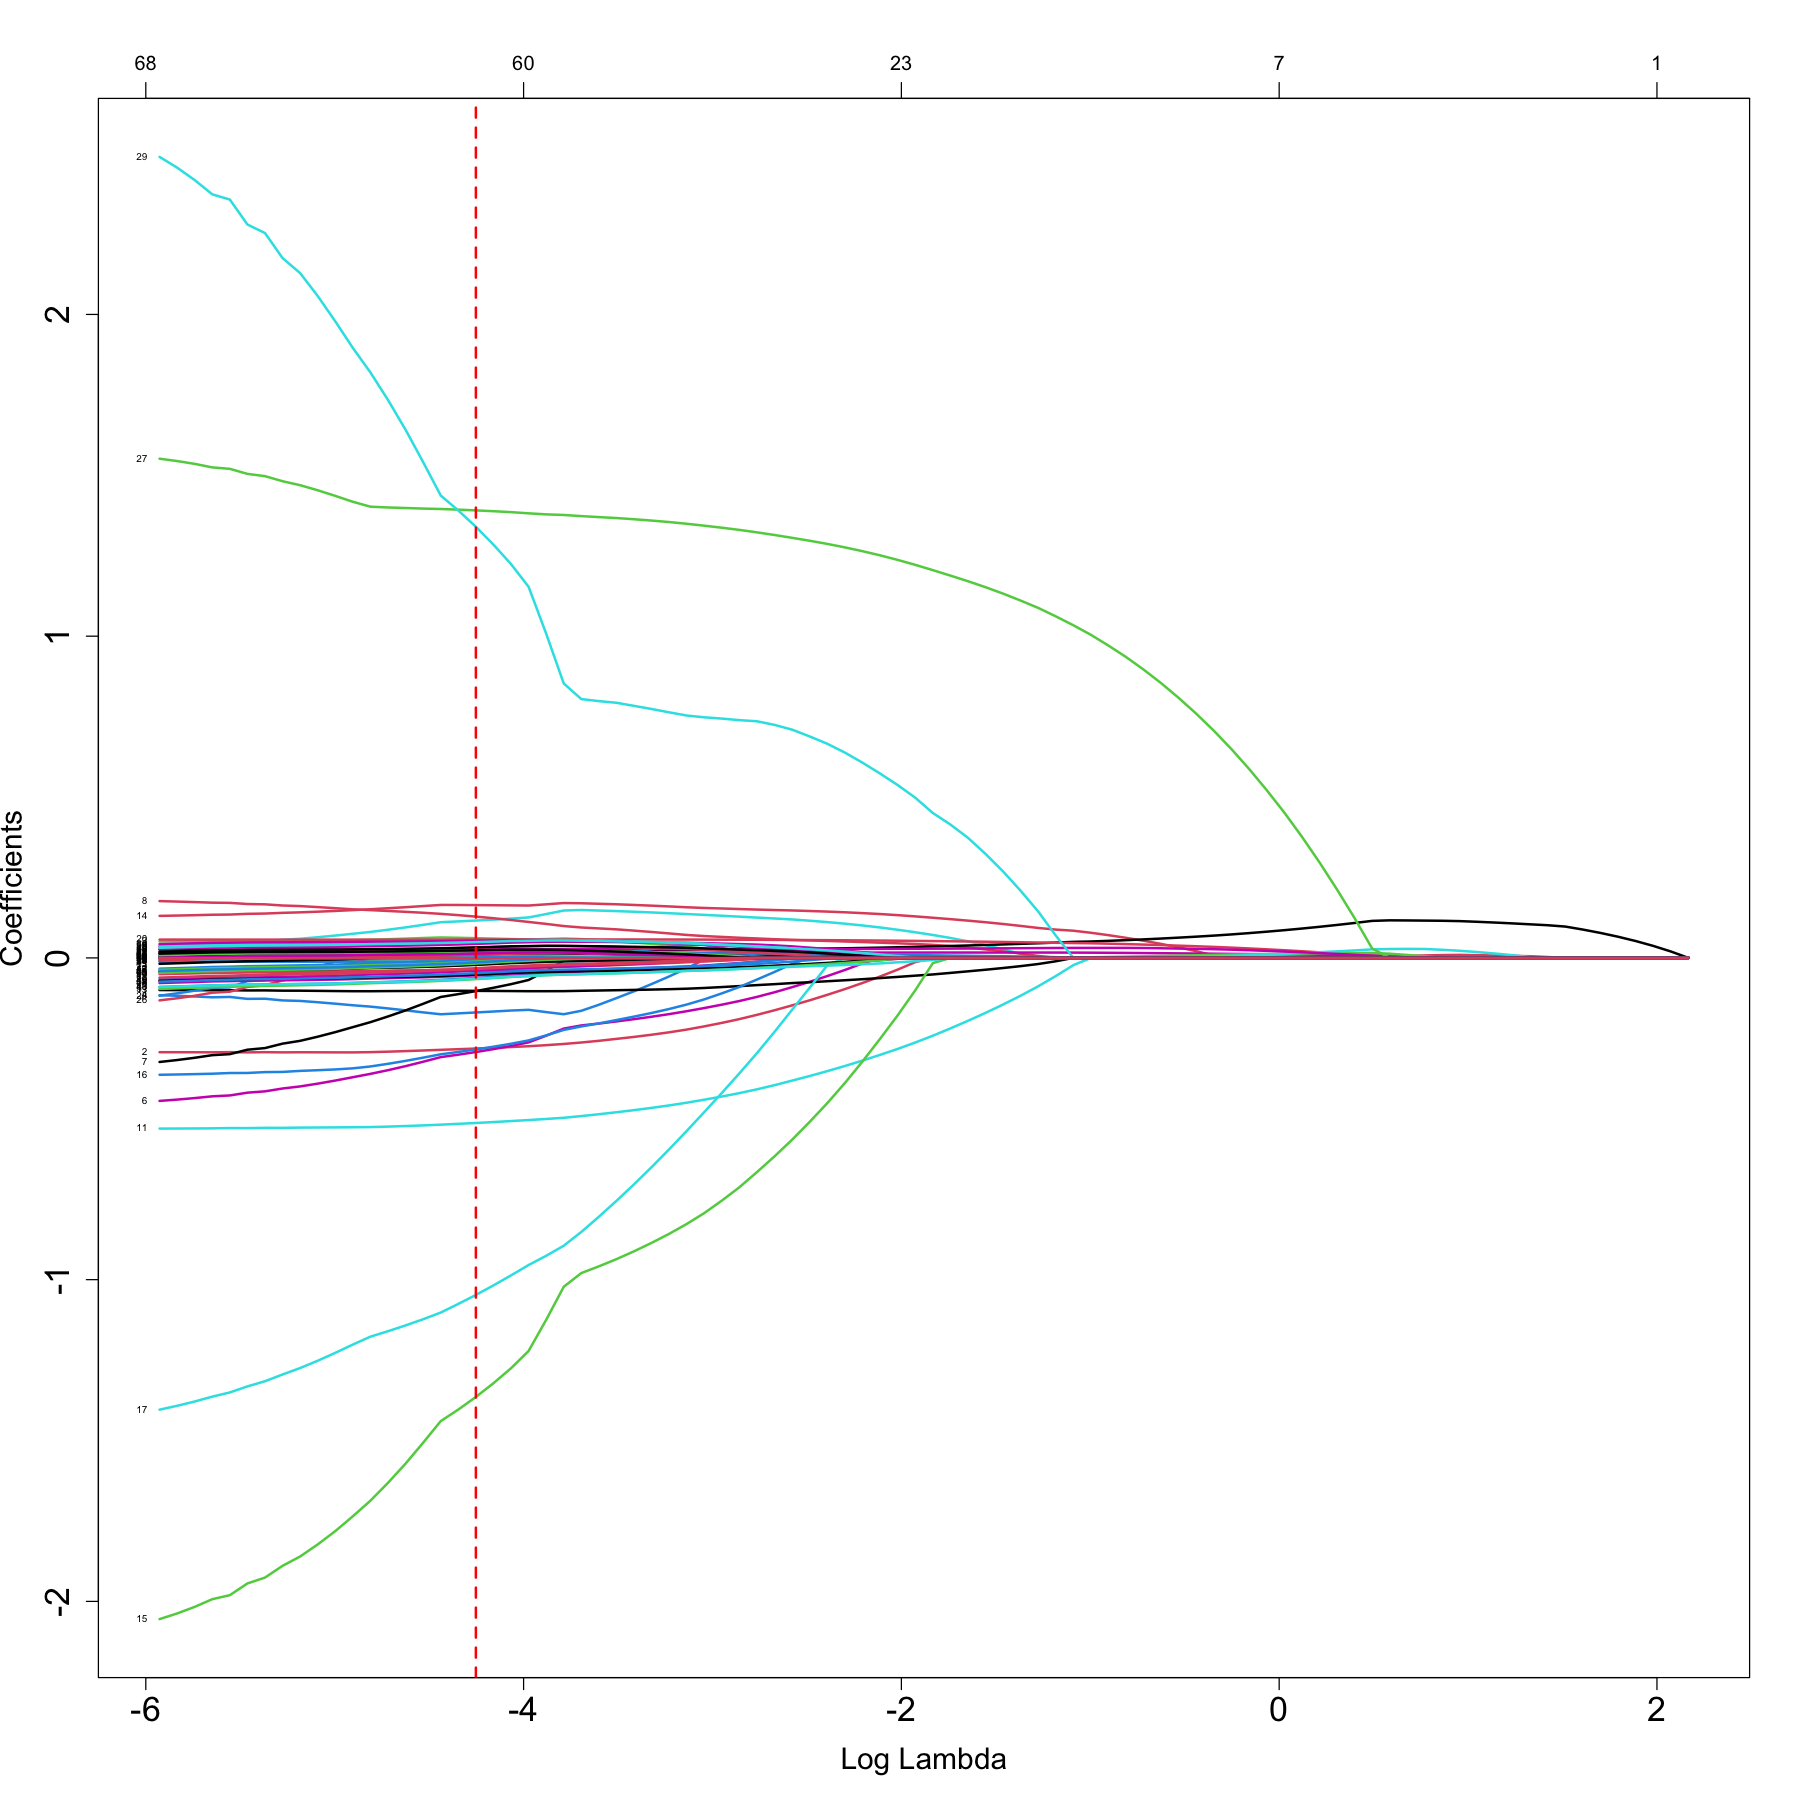

In [84]:
#Plot the Lasso coefficient path
set.seed(123)
plot(lasso_model, xvar = "lambda", label = TRUE, lwd = 2, cex.lab = 1.5, cex.axis = 1.7)
abline(v=log(lasso_cv$lambda.min), col = "red", lty = 2, lwd = 2)


From the Lasso regression coefficients path plot above, the coefficient paths of gTSp,FGp, Patrick Baldwin Jr and Trentyn Flowers stand out and you can see the values of the coefficients selected at the optimal lambda. Next I will perform Elastic net and give equal weight to both lasso and ridge penalties

In [87]:
#Elastic Net
#set seed
set.seed(123)
# 10fold CV to find optimal lambda
elastic_cv <- cv.glmnet(x,y,family = "poisson", alpha = 0.5, nfolds = 10)
opt_lambdaelas <- elastic_cv$lambda.min
print(paste("The optimal lambda value for the elastic net model is", opt_lambdaelas, sep = " "))

[1] "The optimal lambda value for the elastic net model is 0.0259262059951371"


In [89]:
#fit elastic net model with 100 values for lambda
set.seed(123)
elastic_net_model <- glmnet(x,y, family = "poisson", alpha = 0.5,nlambda = 100)

#Extract coefficients at the optimal lambda
coeff_elas<- coef(elastic_net_model, s = opt_lambdaelas)
coeff_elas


69 x 1 sparse Matrix of class "dgCMatrix"
                                                   s1
(Intercept)                              3.2327471049
season                                  -0.0017557459
athlete_display_nameBen Simmons         -0.2841368484
athlete_display_nameBogdan Bogdanovic    0.0626719483
athlete_display_nameCam Christie        -0.1803103824
athlete_display_nameDerrick Jones Jr.    0.1143946526
athlete_display_nameDrew Eubanks        -0.2975768478
athlete_display_nameIvica Zubac         -0.1086044306
athlete_display_nameJames Harden         0.1301978583
athlete_display_nameJordan Miller        .           
athlete_display_nameKawhi Leonard        .           
athlete_display_nameKobe Brown          -0.5132437197
athlete_display_nameKris Dunn           -0.0407992710
athlete_display_nameNicolas Batum       -0.1029378263
athlete_display_nameNorman Powell        0.1643448861
athlete_display_namePatrick Baldwin Jr. -1.3766205666
athlete_display_namePatty Mills         

Elastic Net selected the same predictors as Lasso and therefore also shrunk the coefficient of Kawhi Leonard to zero.

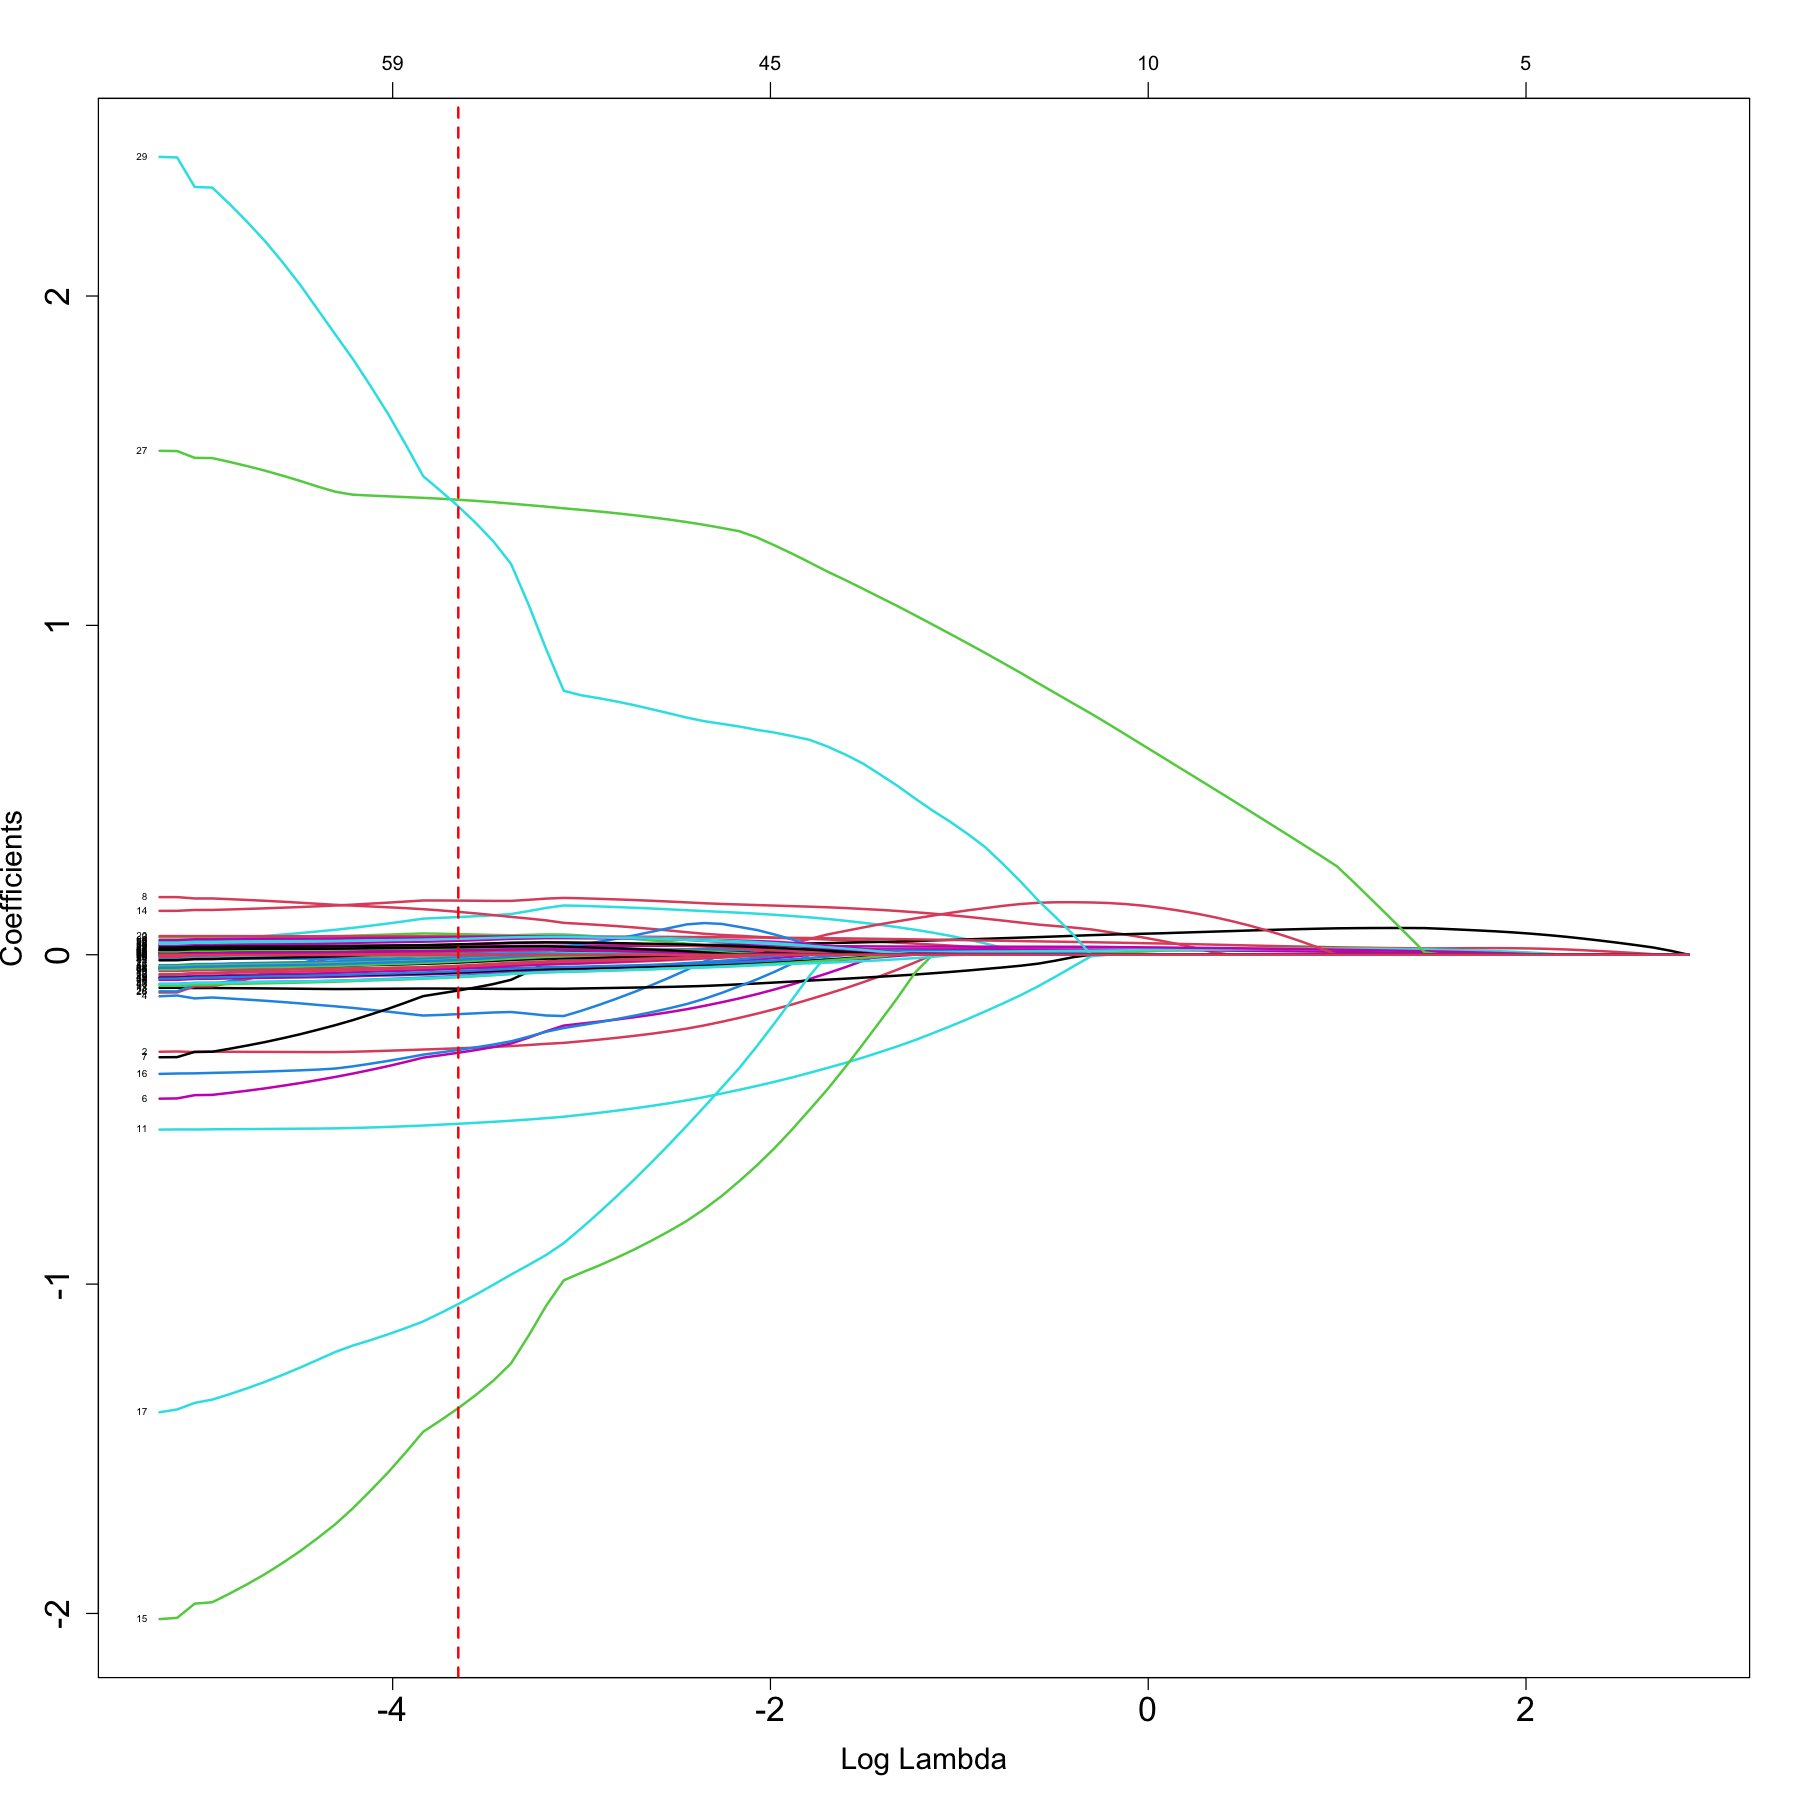

In [93]:
#Plot the elastic net coefficient path
set.seed(123)
plot(elastic_net_model, xvar = "lambda", label = TRUE, lwd = 2,cex.lab = 1.5, cex.axis = 1.7)
abline(v=log(elastic_cv$lambda.min), col = "red", lty = 2, lwd = 2)

From the Elastic Net regression coefficients path plot above, similar to the Lasso model,the coefficient paths of gTSp,FGp, Patrick Baldwin Jr and Trentyn Flowers also stand out and you can see the values of the coefficients selected at the optimal lambda. Next I will perform Ridge Regression.

In [97]:
# Ridge Regression 
#set seed
set.seed(123)
x <- model.matrix(points ~., trainData_adj)[,-1]

y <- trainData_adj$points
# 10fold CV to find optimal lambda
ridge_cv <- cv.glmnet(x,y,family = "poisson", alpha = 0, nfolds = 10)
opt_lambdaridge <- ridge_cv$lambda.min
print(paste("The optimal lambda value for the ridge model is", opt_lambdaridge, sep = " "))

[1] "The optimal lambda value for the ridge model is 0.872954885775677"


In [99]:
#fit ridge model with 100 values for lambda
set.seed(123)
ridge_model <- glmnet(x,y, family = "poisson", alpha = 0,nlambda = 100)

#Extract coefficients at the optimal lambda
coeff_ridge<- coef(ridge_model, s = opt_lambdaridge)
coeff_ridge


69 x 1 sparse Matrix of class "dgCMatrix"
                                                   s1
(Intercept)                             -7.9408330410
season                                   0.0040448941
athlete_display_nameBen Simmons         -0.3050227833
athlete_display_nameBogdan Bogdanovic    0.0673013906
athlete_display_nameCam Christie        -0.3121503724
athlete_display_nameDerrick Jones Jr.    0.1389785677
athlete_display_nameDrew Eubanks        -0.2355180139
athlete_display_nameIvica Zubac         -0.0139301996
athlete_display_nameJames Harden         0.0762557845
athlete_display_nameJordan Miller       -0.0338959891
athlete_display_nameKawhi Leonard        0.0528575507
athlete_display_nameKobe Brown          -0.4197194643
athlete_display_nameKris Dunn           -0.0848783859
athlete_display_nameNicolas Batum       -0.1168179369
athlete_display_nameNorman Powell        0.1917591526
athlete_display_namePatrick Baldwin Jr. -0.9374903523
athlete_display_namePatty Mills         

As expected, Ridge Regression selected all the predictors and spread the weights of the player coefficients much more among the three top scorers in LAC than LASSO and Elastic Net did.

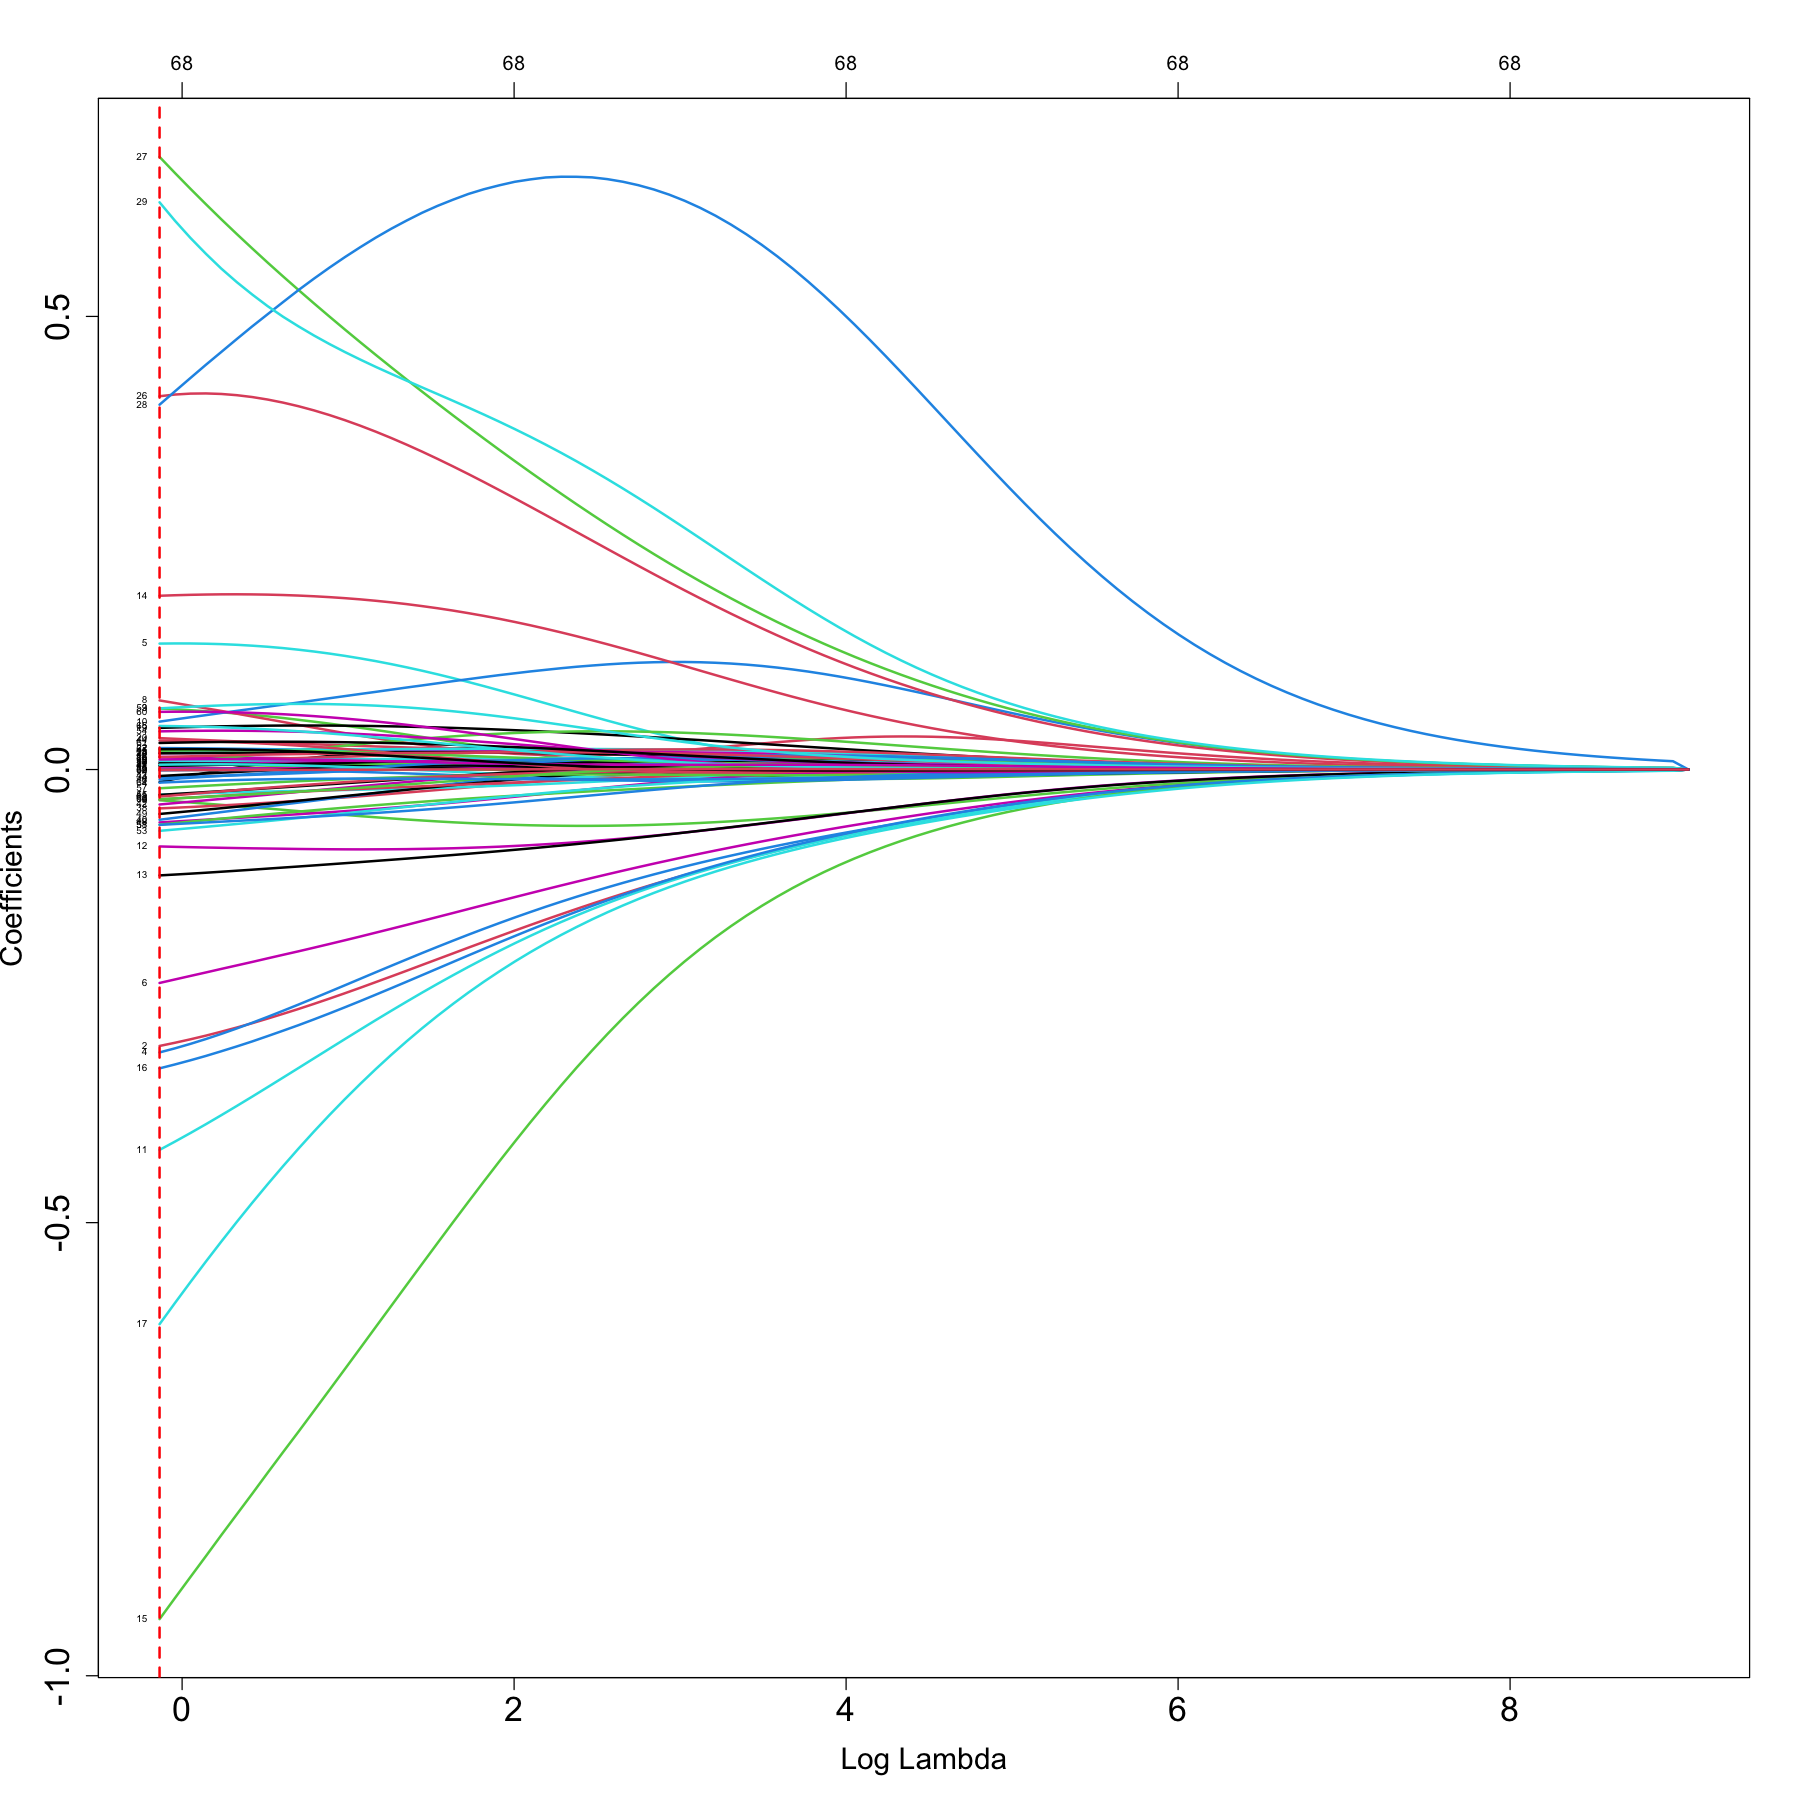

In [103]:
#Plot the ridge coefficient path
set.seed(123)
plot(ridge_model, xvar = "lambda", label = TRUE, lwd = 2,cex.lab = 1.5, cex.axis = 1.7)
abline(v=log(ridge_cv$lambda.min), col = "red", lty = 2, lwd = 2)

The coefficient paths of the ridge regression model is the smoothest of the three regularized regression model and it reduced a lot of predictors coefficients close to zero. This is not surprising given the multicollinearity problem of the full model. Next we will evaluate the prediction accuracy of the full model and the reduced models. 

### Prediction

In [106]:
# Calculate Prediction accuracy evaluation using test dataset (Calculate MSPE, RMSE and Precision Measure ) 
# Use PM to select best predictive model 
set.seed(123)
#clean test data
testData_adj <- subset(testData,select = -c(game_date, rebounds))
testData_fin <- testData_adj[1:(length(testData_adj)-1)]

# convert test data to correct form for the regularized models
actual_pred <- testData_adj$points
x_testData <- model.matrix(points ~., testData_adj)[,-1]

#Functions to calculate MSPE and PM
# Root Mean Squared Prediction Error (RMSE)
rmse_fun <- function(pred,dat){sqrt(mean((pred-dat)^2))}

# Precision Measure (PM)
pm_fun <- function(pred,dat){sum((pred-dat)^2)/sum((dat-mean(dat))^2) }

#prediction from all models
full_modelpred <- predict(full_model,testData_fin,type = "response")

stepwise_forwardaic_pred <- predict(stepwise_forwardAIC,testData_fin,type = "response")

stepwise_backbic_pred <- predict(stepwise_backBIC,testData_fin,type = "response")

lasso_pred <- predict(lasso_model,x_testData,s = opt_lambdalass, type = "response")

elastic_net_pred <- predict(elastic_net_model,x_testData,s = opt_lambdaelas, type = "response")
ridge_pred <- predict(ridge_model,x_testData,s = opt_lambdaridge, type = "response")

predictions = data.frame(Player_Name = testData_adj$athlete_display_name, Actual_points=actual_pred, Full_modelpred=full_modelpred,
                         Stepwise_forwardAICpred = stepwise_forwardaic_pred, Stepwise_BackwardBICpred = stepwise_backbic_pred,
                         Lasso_pred =lasso_pred[,1], ElasticNet_pred = elastic_net_pred[,1],Ridge_pred =ridge_pred[,1]
                        )
head(predictions,10)



,Player_Name,Actual_points,Full_modelpred,Stepwise_forwardAICpred,Stepwise_BackwardBICpred,Lasso_pred,ElasticNet_pred,Ridge_pred
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
43771,Amir Coffey,0,1.282621,1.349753,1.329843,1.458225,1.461268,1.778382
10878,Kawhi Leonard,23,23.893075,24.769397,23.992622,23.593119,23.605111,23.243686
103345,Kris Dunn,2,3.155440,3.154854,3.155750,3.216037,3.219085,3.333739
79097,Kawhi Leonard,21,18.117121,16.726847,16.136836,17.552803,17.588765,18.179825
83345,Norman Powell,17,15.062582,15.597413,15.562133,15.061845,15.036396,14.352584
83360,Norman Powell,14,11.408087,11.674422,11.790777,11.206781,11.225315,11.287990
76248,James Harden,28,25.526921,25.100943,24.240152,24.838979,24.890368,25.371296
91337,Bogdan Bogdanovic,2,3.062213,3.076494,3.084296,3.036562,3.051632,3.436631
55260,Kawhi Leonard,11,8.092523,8.001450,7.642472,7.914137,7.940008,8.304425


In [108]:
#Calculate Performance metrics
set.seed(123)
full_model_rmse <- rmse_fun(full_modelpred,actual_pred)
full_model_pm <- pm_fun(full_modelpred,actual_pred)
stepwise_forwardaic_rmse <- rmse_fun(stepwise_forwardaic_pred,actual_pred)
stepwise_forwardaic_pm <- pm_fun(stepwise_forwardaic_pred,actual_pred)
stepwise_backbic_rmse <- rmse_fun(stepwise_backbic_pred,actual_pred)
stepwise_backbic_pm <- pm_fun(stepwise_backbic_pred,actual_pred)
lasso_rmse <- rmse_fun(lasso_pred,actual_pred)
lasso_pm <- pm_fun(lasso_pred,actual_pred)
elastic_net_rmse <- rmse_fun(elastic_net_pred,actual_pred)
elastic_net_pm <- pm_fun(elastic_net_pred,actual_pred)
ridge_rmse <- rmse_fun(ridge_pred,actual_pred)
ridge_pm <- pm_fun(ridge_pred,actual_pred)

#Create summary dataframe
metrics_summary <- data.frame( 
    "Type of Model" = c(
        "Full Model",
        "Stepwise Forward using AIC",
        "Stepwise Backward using BIC",
        "Lasso Model",
        "Elastic Net Model",
        "Ridge Model"),
    "RMSE" = c(full_model_rmse,
              stepwise_forwardaic_rmse,
              stepwise_backbic_rmse,
              lasso_rmse,
              elastic_net_rmse,
              ridge_rmse 
              ),
    "PM" = c(full_model_pm,
              stepwise_forwardaic_pm,
              stepwise_backbic_pm,
              lasso_pm,
              elastic_net_pm,
              ridge_pm
              ))

print(metrics_summary)

                Type.of.Model     RMSE         PM
1                  Full Model 2.885236 0.10181588
2  Stepwise Forward using AIC 2.771688 0.09395966
3 Stepwise Backward using BIC 2.815429 0.09694866
4                 Lasso Model 2.761795 0.09329015
5           Elastic Net Model 2.760787 0.09322205
6                 Ridge Model 2.606706 0.08310686


Based on the summary table above, the Ridge model had the lowest RMSE and PM and thus is selected to be the best Poisson model. This is not surprising ,based on the multicollinearity issues with this dataset I will expect the Ridge Regression Poisson model to outperform the other models.


### Conclusion

Using detailed game specific NBA data, multiple Poisson Regression models were built to predict single game points for each player in the 2025 season Los Angeles Clippers team. Exploratory data analysis(EDA) was conducted to gain insights to trends and patterns within the dataset used to build the Poisson model.  EDA identified multicollinearity as an issue in our dataset and this was addressed using variable selection and regularized regression techniques. Based on the comparison of multiple prediction measures , the Ridge Regression Poisson model was selected as the best model out of the multiple Poisson models built. 

Based on the fact that the dataset had more season games than playoffs game, it's predictive accuracy may be skewed towards more accurate predictions for season games. Possible future extension of this project that could address this bias could include incorporating more playoffs specific predictors e.g. a categorical predictor that indicates if a particular game determines if the team moves on to the next playoffs round. Also accounting for player interdependence within a team should lead to a more robust model for example every time James Harden takes a shot, it is an attempt that Kawhi Leonard does not get — thus directly limiting Leonard's scoring upside. Predicting a team’s collective scoring dynamics, rather than modeling players independently, would be an exiciting next challenge and should result in a more robust model.

